In [5]:
# python peripherals
import os
from argparse import ArgumentParser
from os import walk
from pathlib import Path
import pathlib
import queue
from multiprocessing import Process, Queue, cpu_count
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# skimage
import skimage.io
import skimage.color
import skimage.measure

# common
from utils import common as common_utils
from utils import settings

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# deep-signature
from deep_signature.data_manipulation import curve_sampling, curve_processing
from deep_signature.stats import discrete_distribution
from deep_signature.linalg import transformations

# shapely
from shapely.geometry import Polygon

In [6]:
def plot_graph(ax, x, y, linewidth=2, color='red', alpha=1, zorder=1, label=None):
    return ax.plot(x, y, linewidth=linewidth, color=color, alpha=alpha, zorder=zorder, label=label)


def plot_curve(ax, curve, linewidth=2, color='red', alpha=1, zorder=1, label=None):
    x = curve[:, 0]
    y = curve[:, 1]
    return plot_graph(ax=ax, x=x, y=y, linewidth=linewidth, color=color, alpha=alpha, zorder=zorder, label=label)


def plot_sample(ax, sample, color, zorder, point_size=10, alpha=1, x=None, y=None):
    if sample is not None:
        x = sample[:, 0]
        y = sample[:, 1]

    return ax.scatter(
        x=x,
        y=y,
        s=point_size,
        color=color,
        alpha=alpha,
        zorder=zorder)


# def extract_curves(curves, curves_dir, stem):
#     sampling_ratios = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3]
#     multimodalies = [10, 15, 20, 25, 30, 35, 40, 45]
#     transform_types = ['euclidean', 'equiaffine', 'affine']

#     for transform_type in transform_types:
#         transformed_curves = []
#         for curve in curves:
#             transform = transformations.generate_random_transform_2d_evaluation(transform_type=transform_type)
#             transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)
#             transformed_curves.append(transformed_curve)

#         for multimodality in multimodalies:
#             for sampling_ratio in sampling_ratios:
#                 downsampled_curves = []
#                 plots_file_path = os.path.normpath(os.path.join(curves_dir, 'plots', stem, transform_type, f'multimodality_{multimodality}', str(sampling_ratio).replace(".", "_")))
#                 pathlib.Path(plots_file_path).mkdir(parents=True, exist_ok=True)
#                 current_curves = transformed_curves if sampling_ratio < 1 else curves
#                 for i, curve in enumerate(current_curves):
#                     curve_points_count = curve.shape[0]
#                     sampling_points_count = int(sampling_ratio * curve_points_count)
#                     dist = discrete_distribution.random_discrete_dist(bins=curve_points_count, multimodality=multimodality, max_density=1, count=1)[0]
#                     indices_pool = discrete_distribution.sample_discrete_dist(dist=dist, sampling_points_count=sampling_points_count)
#                     downsampled_curve = curve[indices_pool]
#                     downsampled_curves.append(downsampled_curve)

#                     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
#                     if sampling_ratio < 1:
#                         plot_sample(ax=ax, sample=curves[i], color='green', zorder=10, point_size=4)

#                     plot_sample(ax=ax, sample=downsampled_curve, color='red', zorder=10, point_size=4)
#                     plt.axis('off')
#                     ax.axis('equal')
#                     plot_file_path = os.path.normpath(os.path.join(plots_file_path, f'{stem}_{i}.png'))
#                     fig.savefig(plot_file_path)
#                     plt.close(fig)

#                 curves_base_dir_path = os.path.normpath(os.path.join(curves_dir, transform_type, f'multimodality_{multimodality}'))
#                 pathlib.Path(curves_base_dir_path).mkdir(parents=True, exist_ok=True)
#                 curves_file_path = os.path.normpath(os.path.join(curves_base_dir_path, f'{stem}_{str(sampling_ratio).replace(".", "_")}.npy'))
#                 numpy.save(curves_file_path, downsampled_curves)

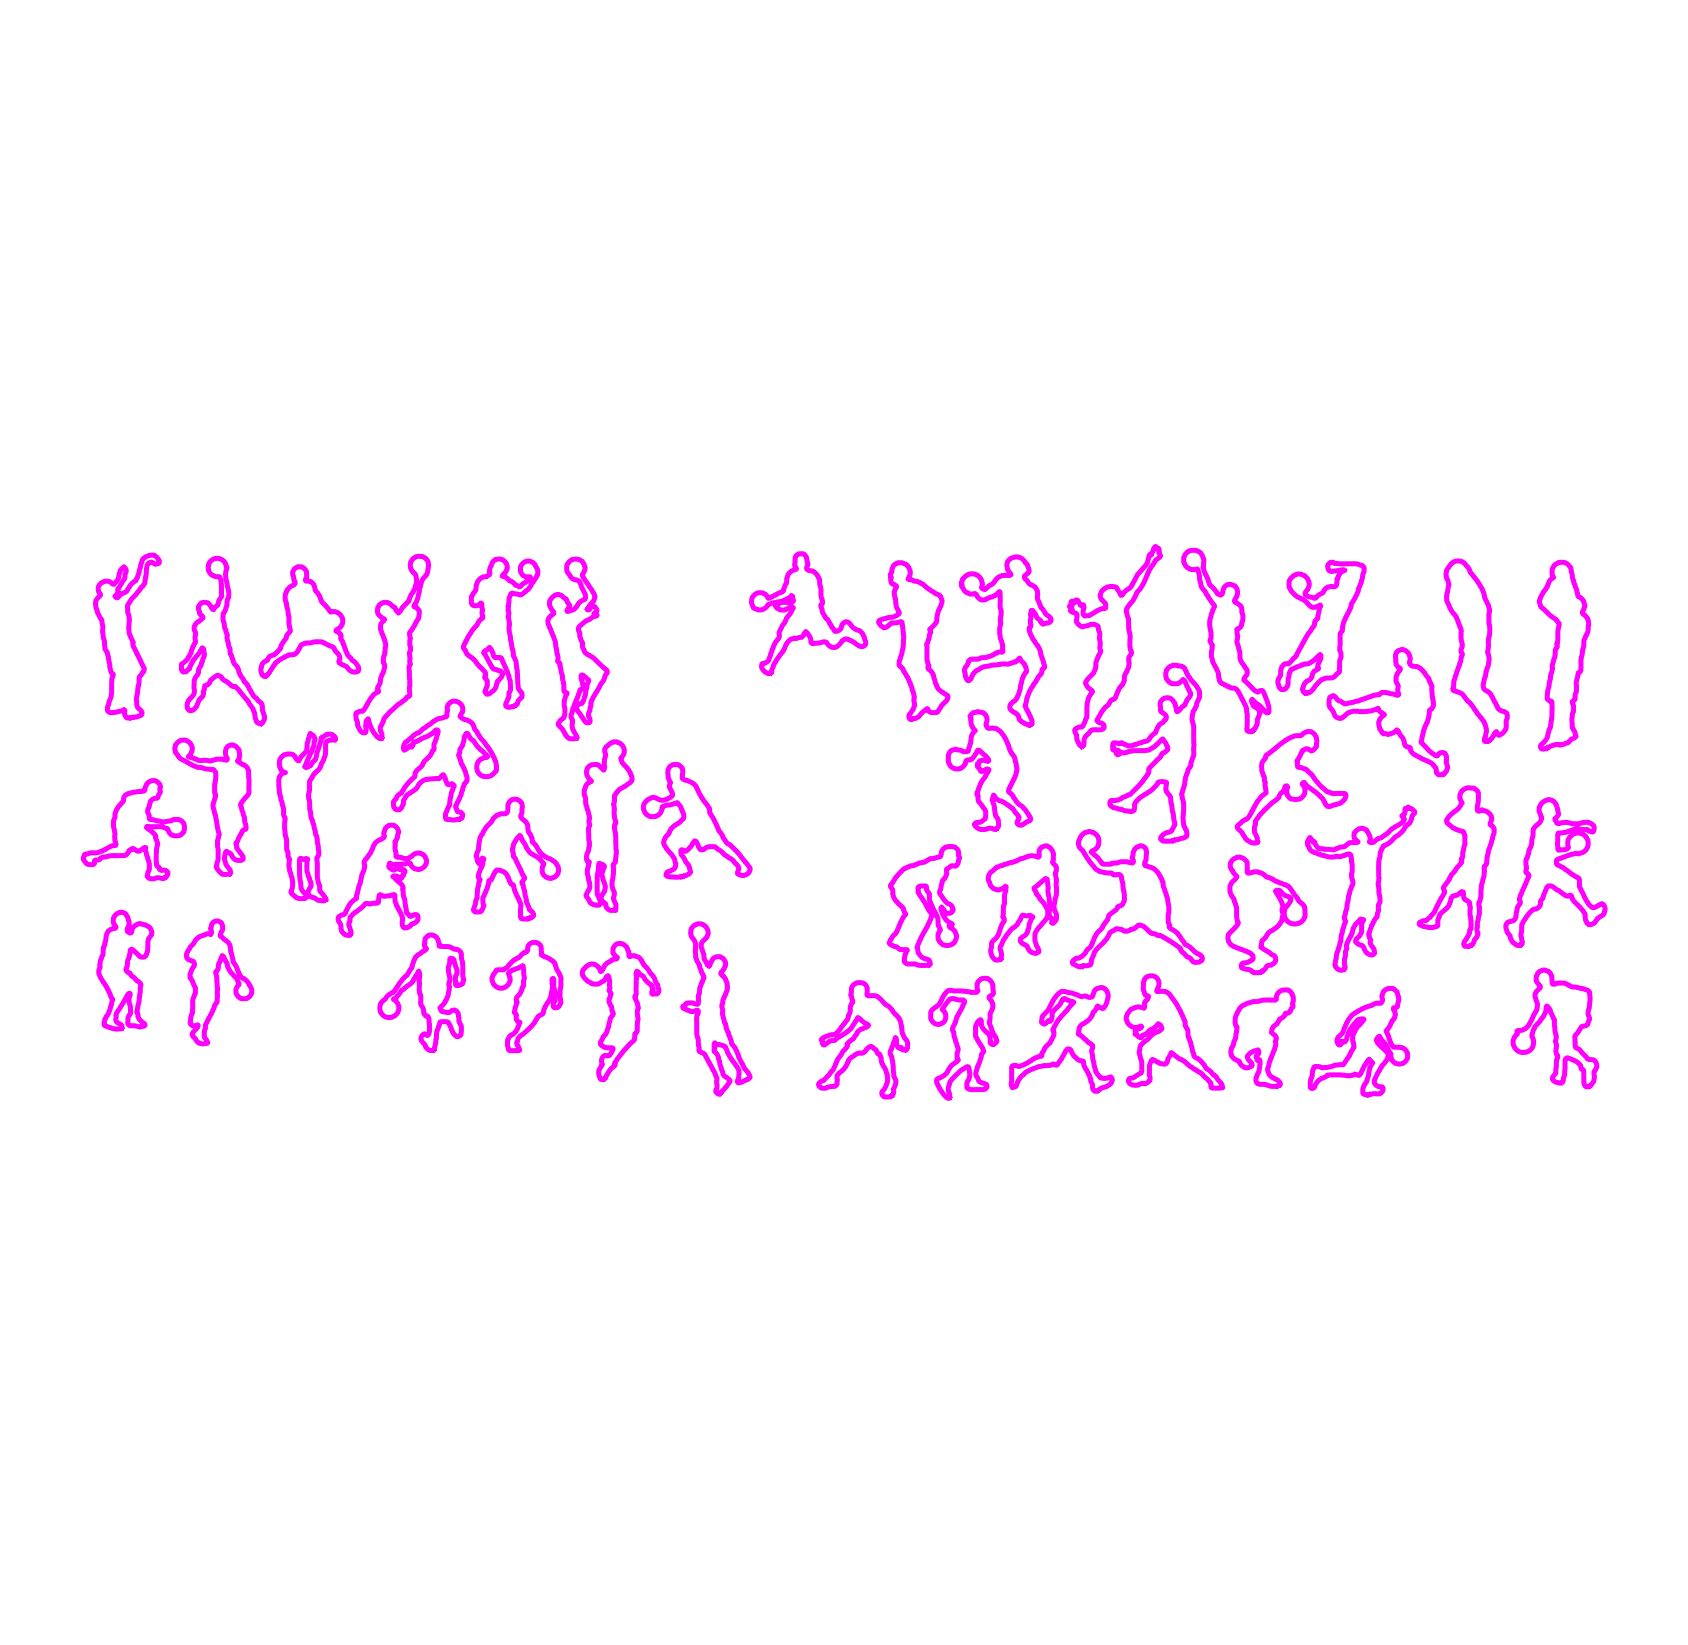

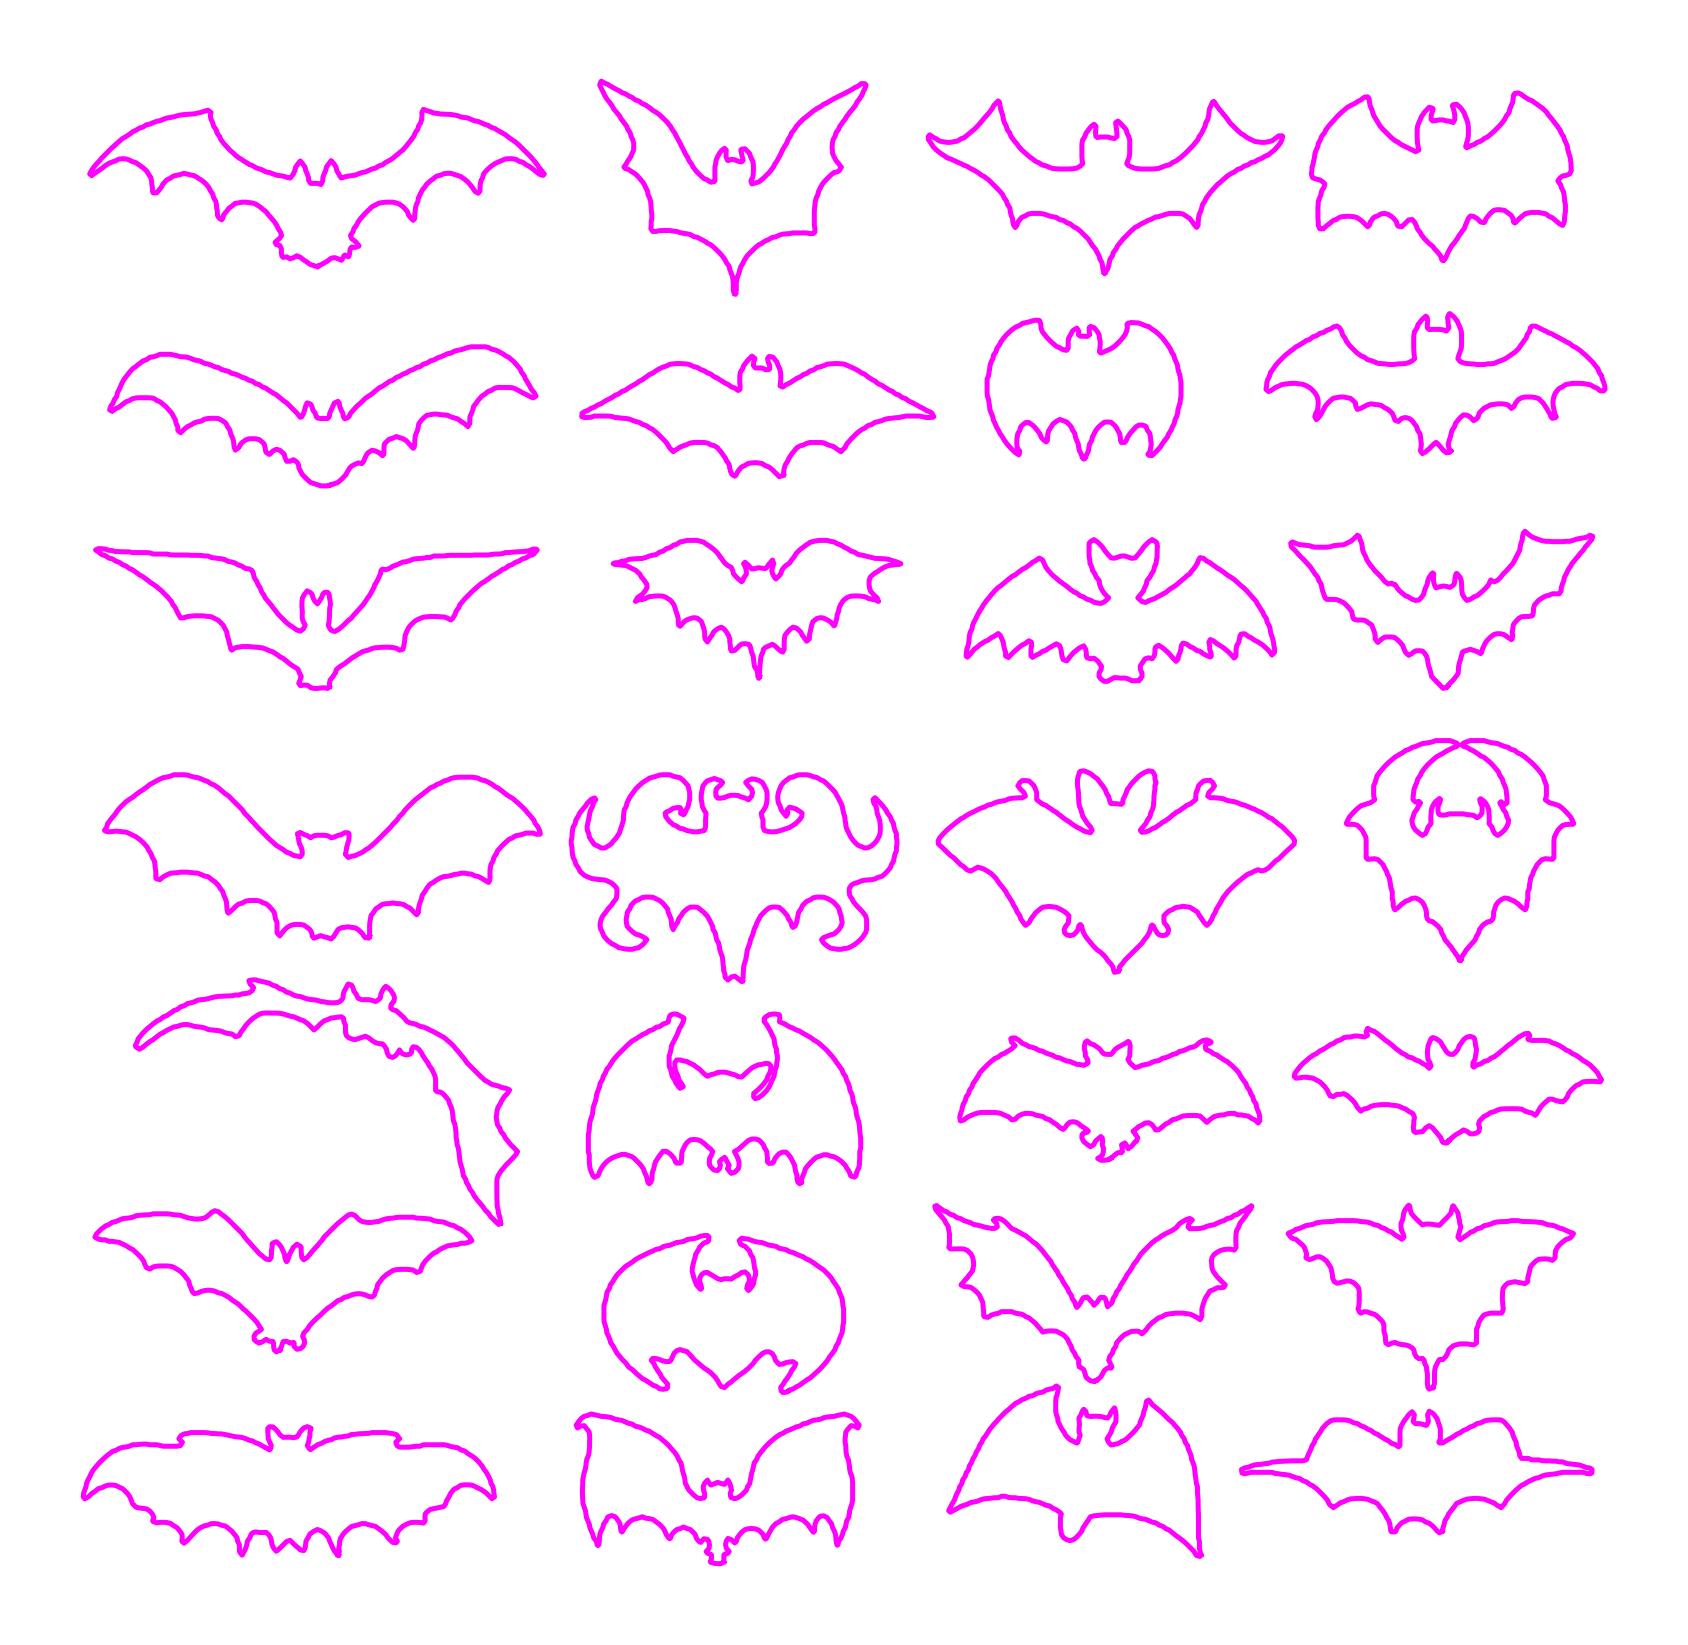

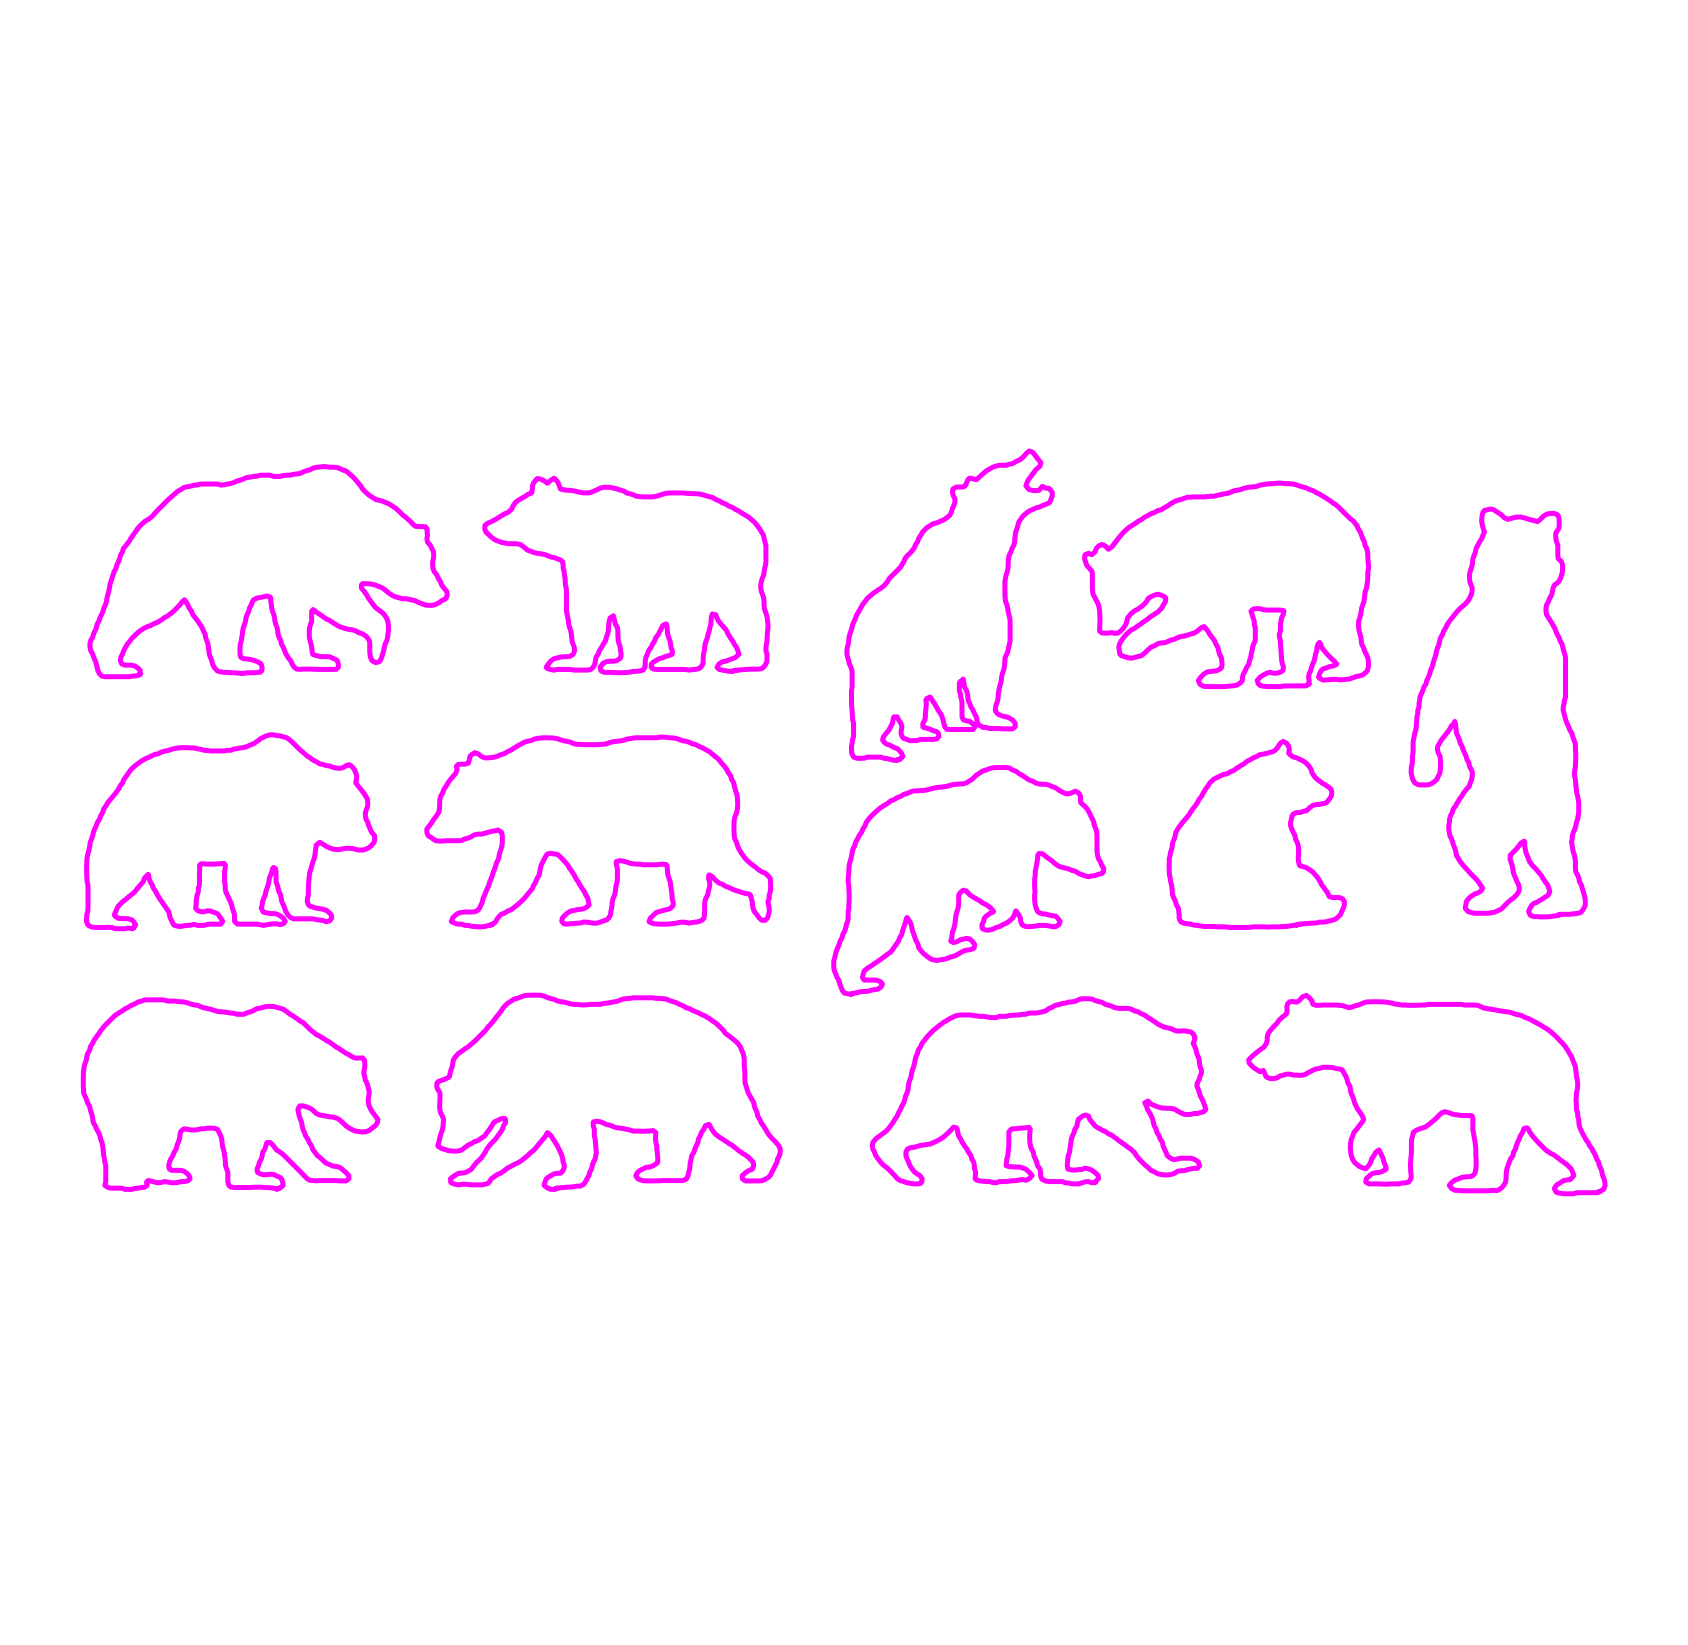

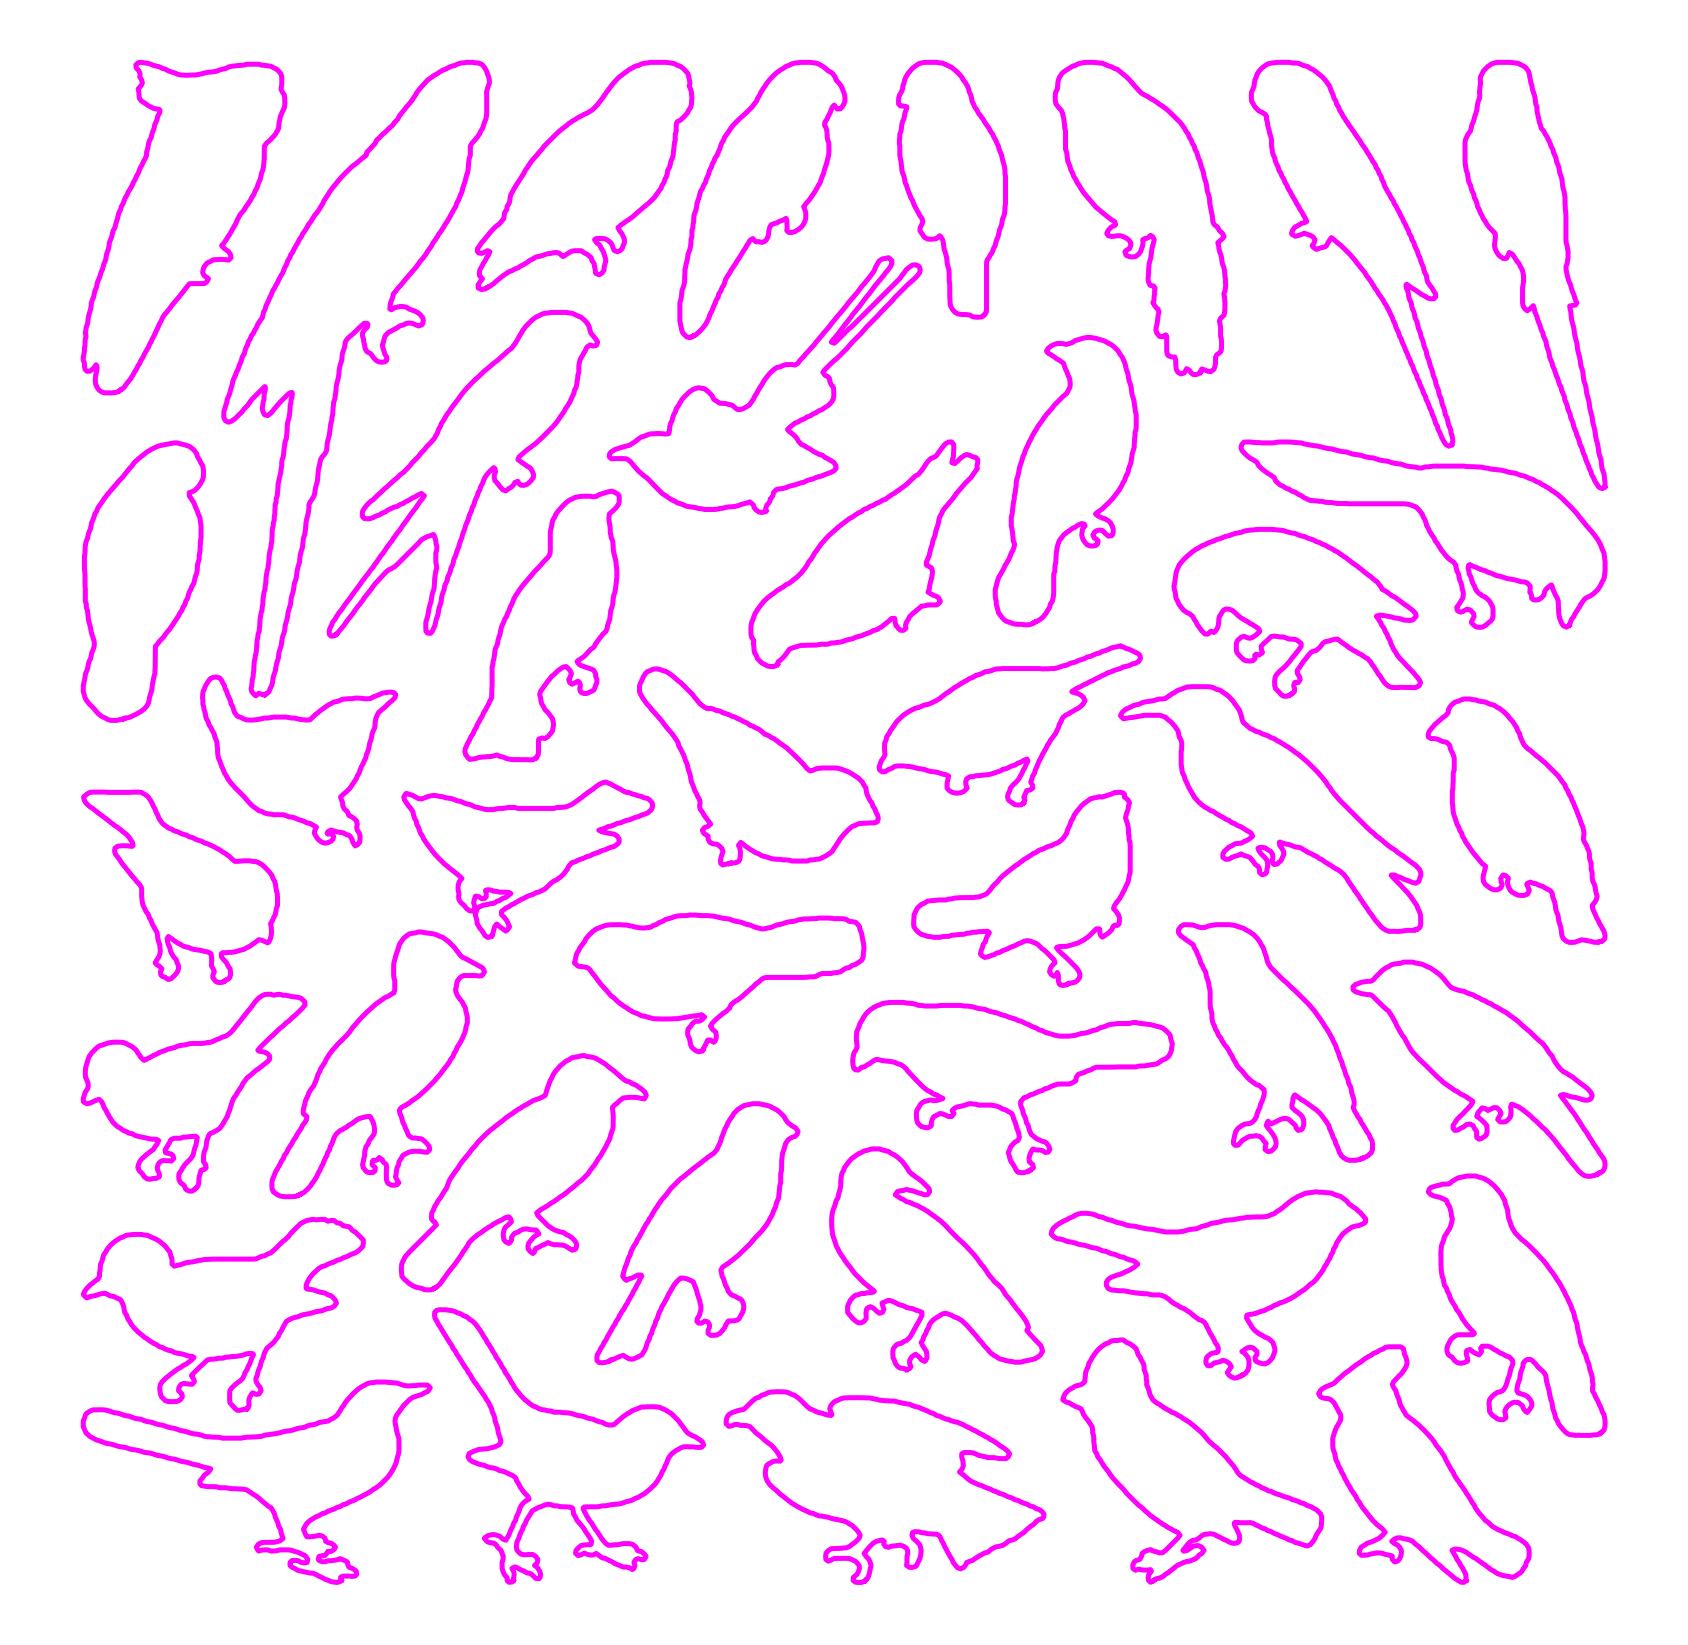

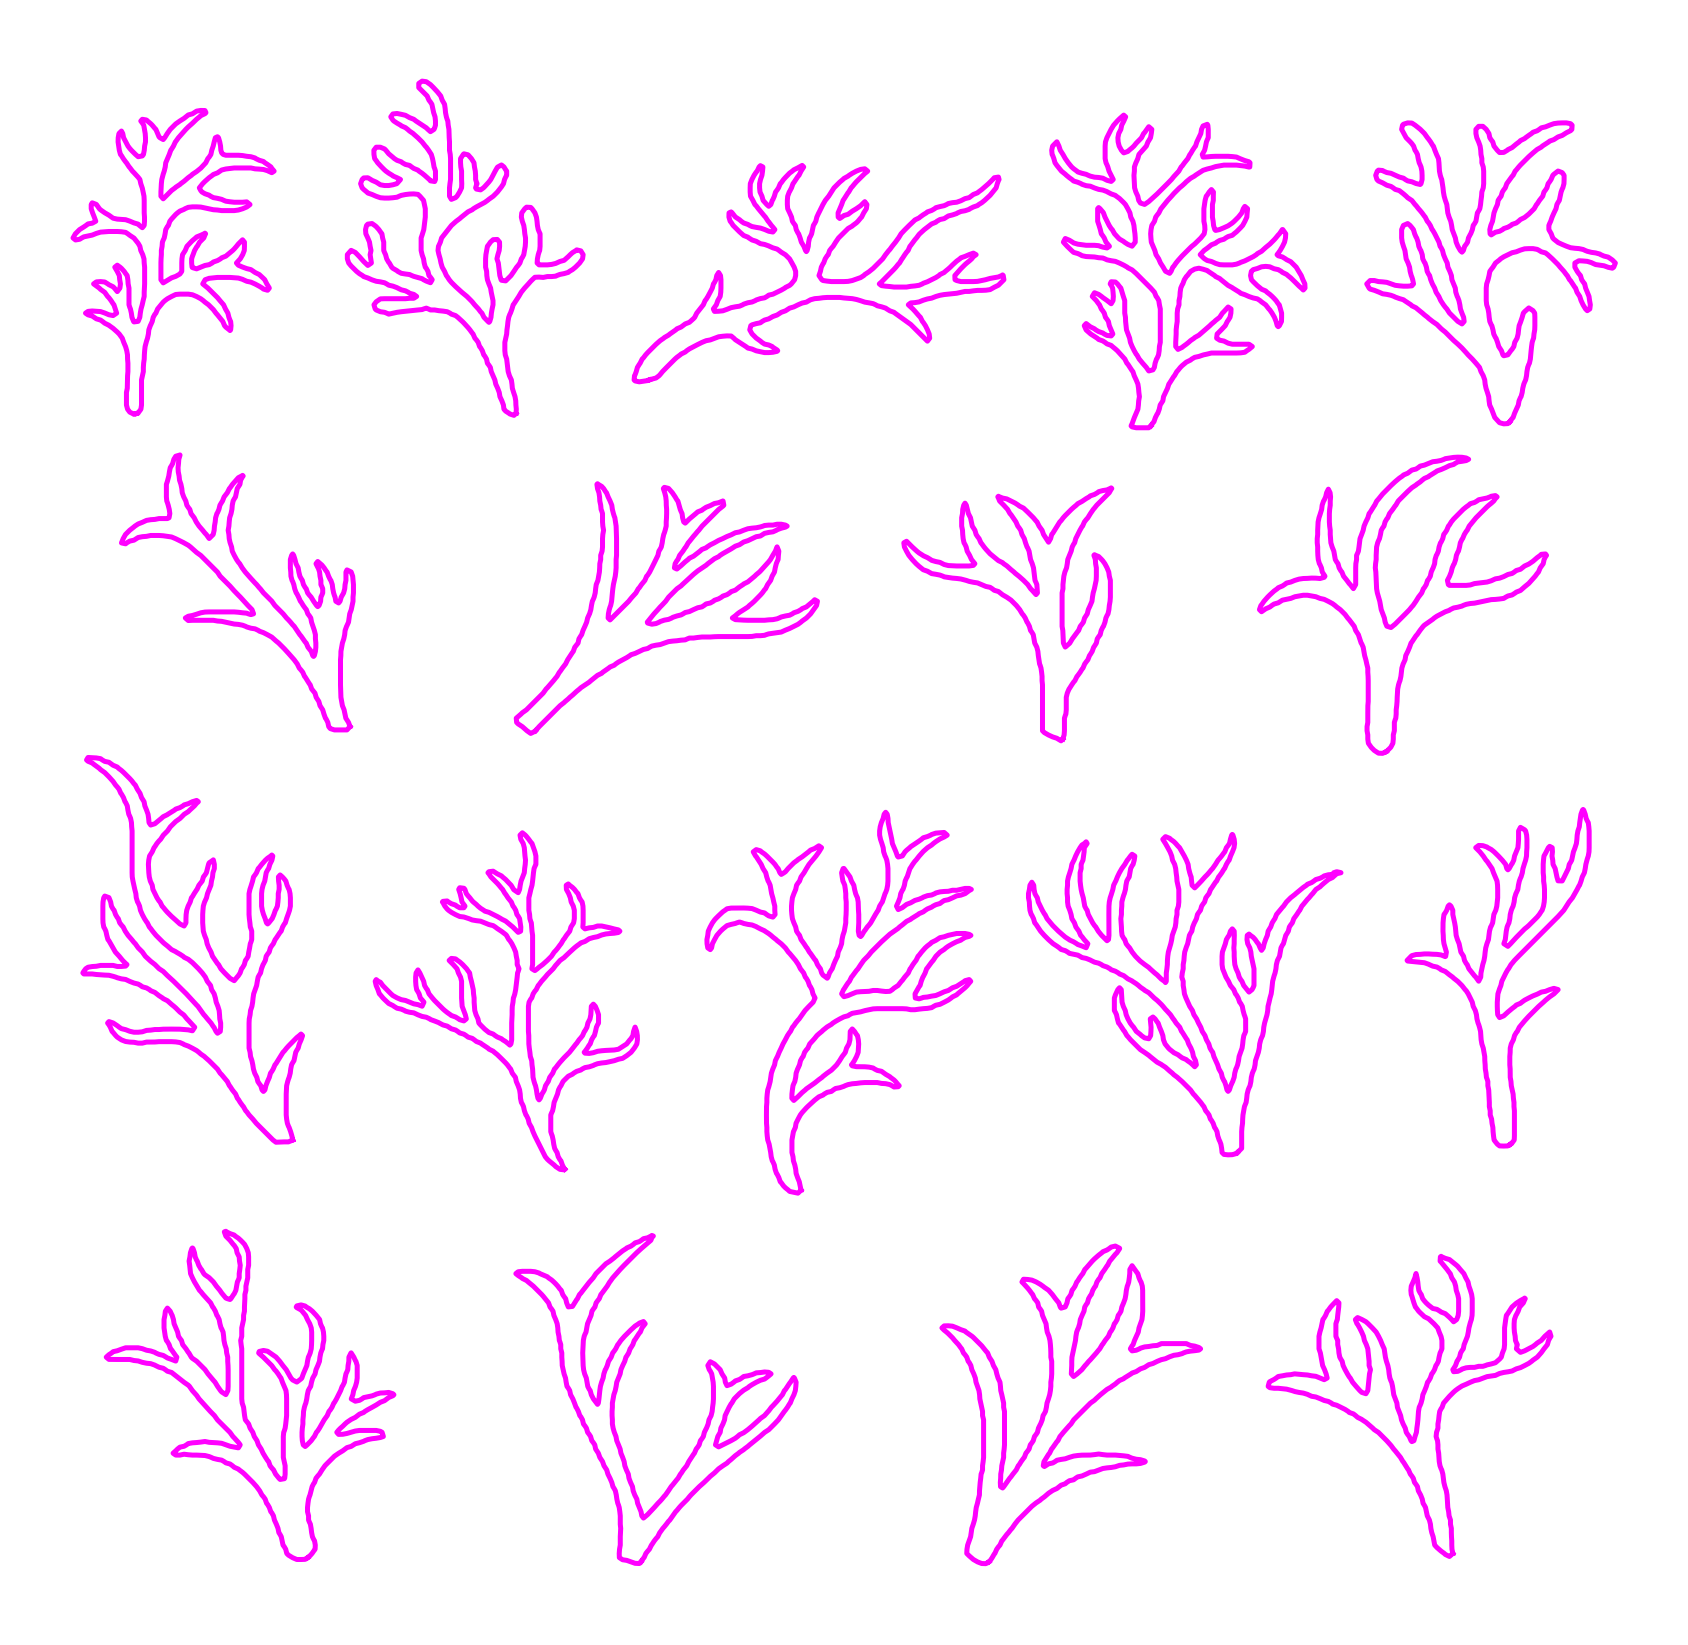

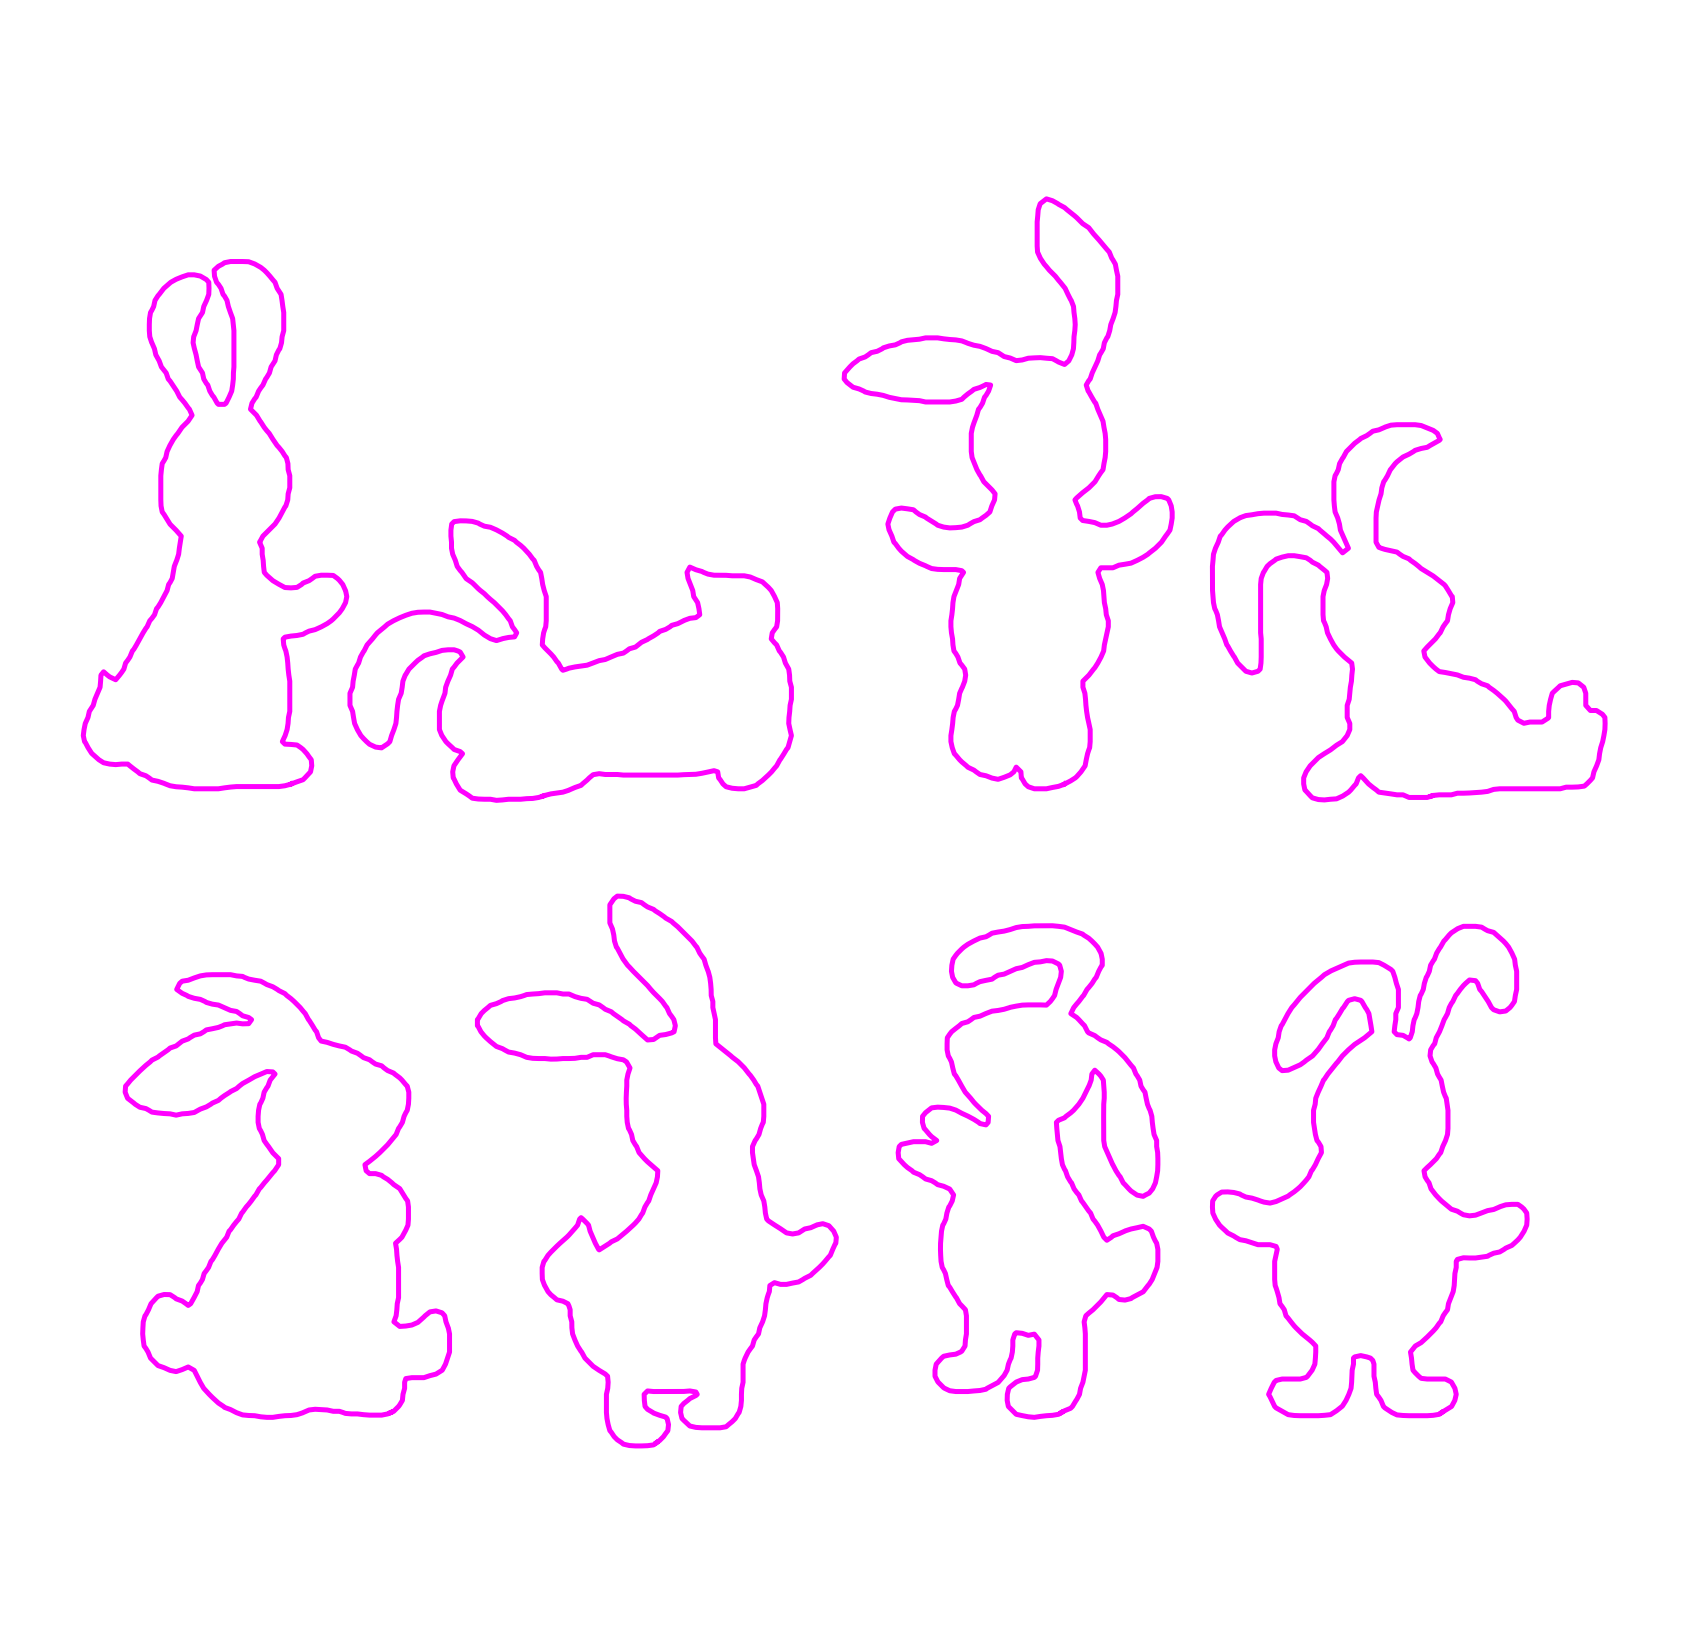

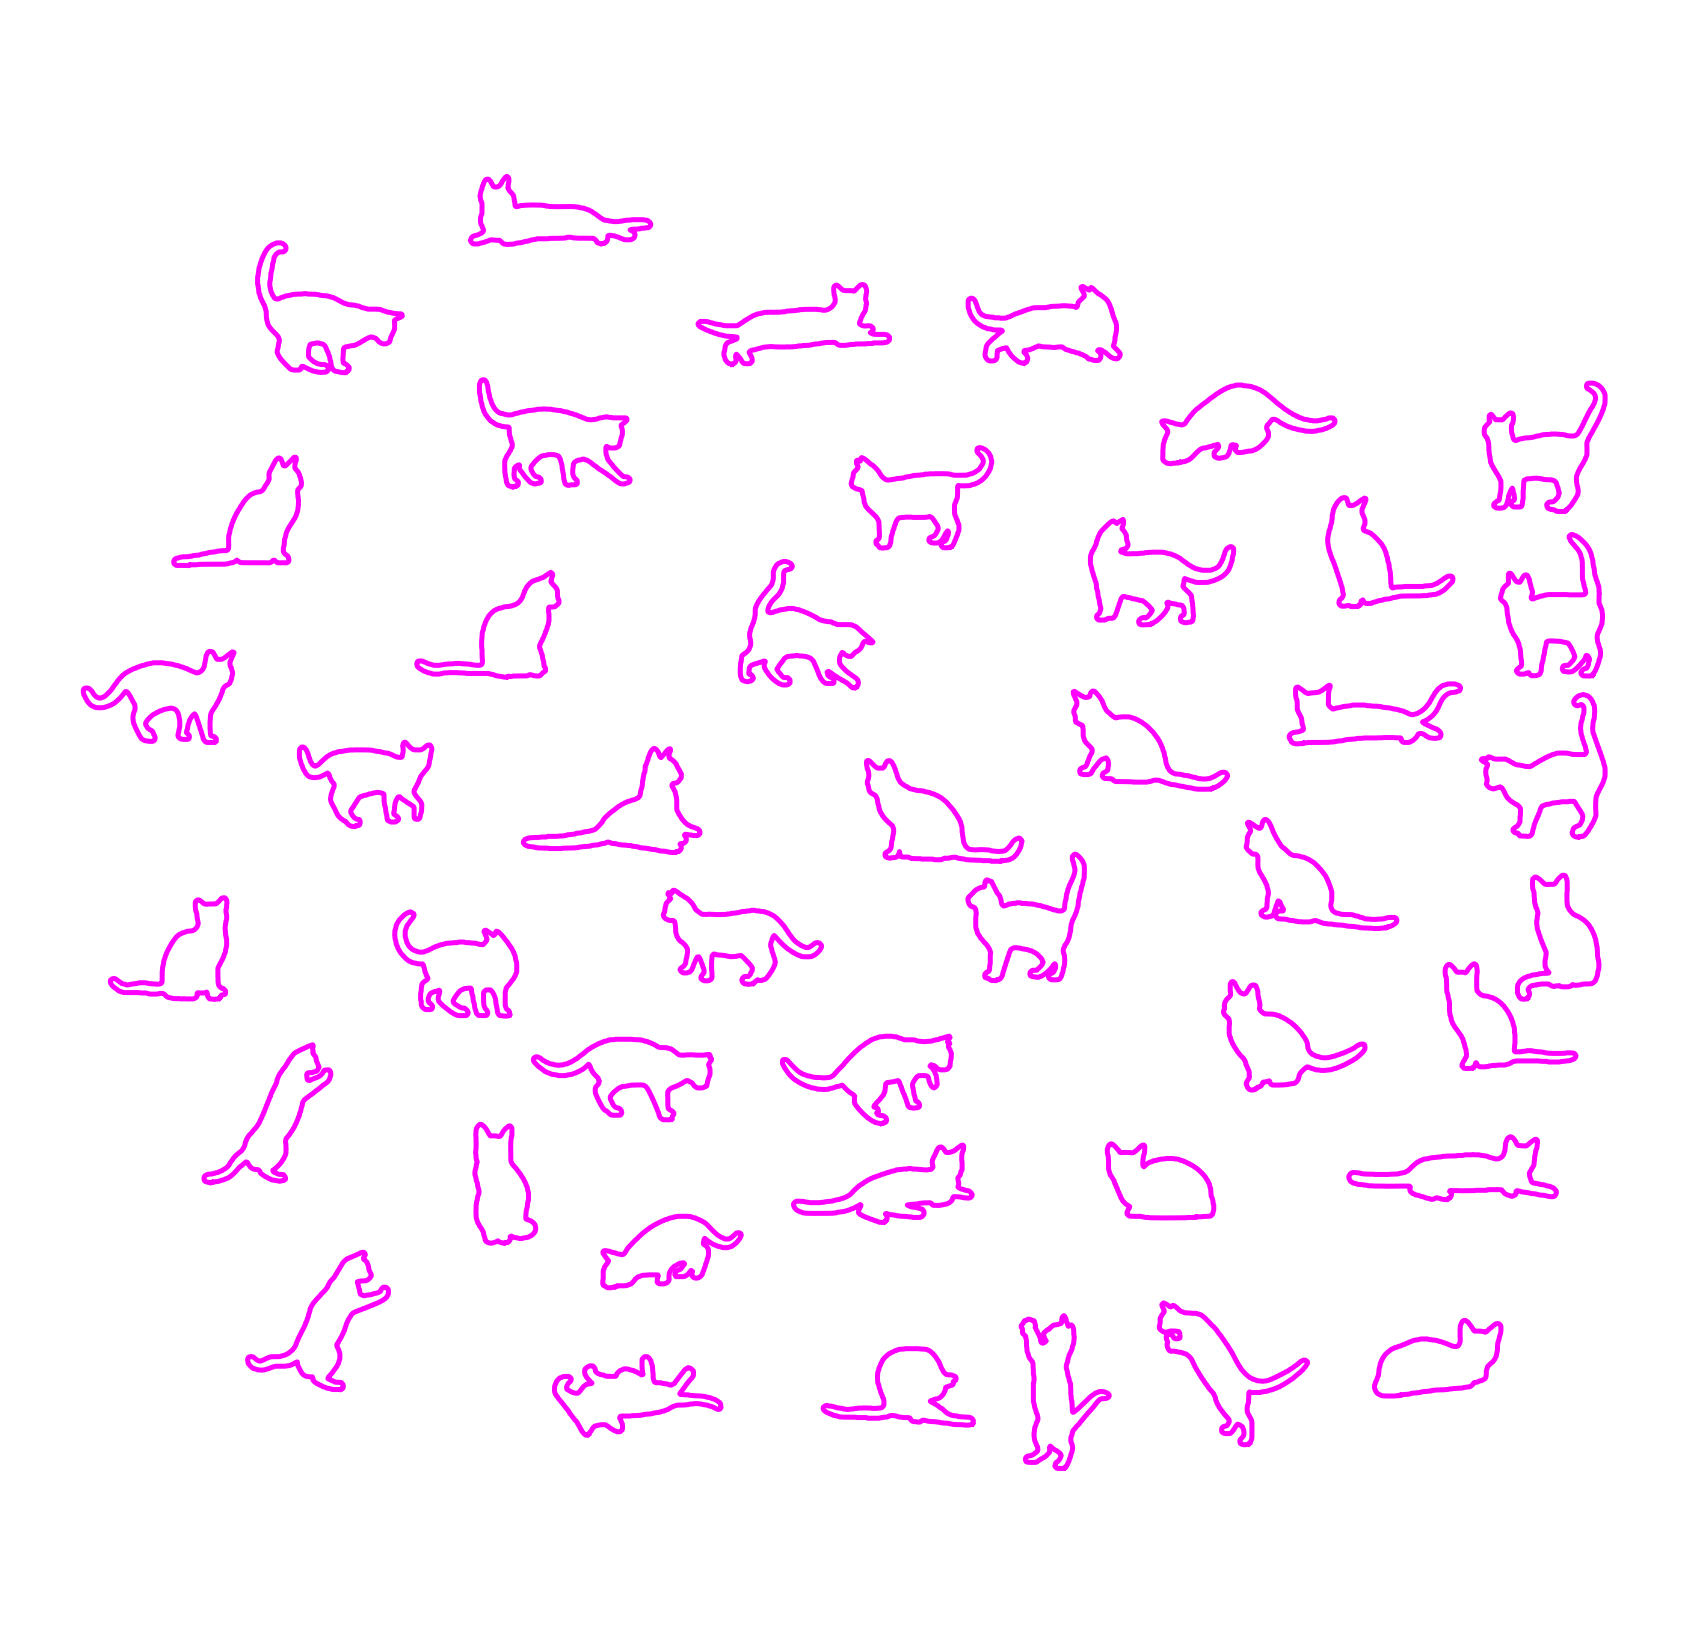

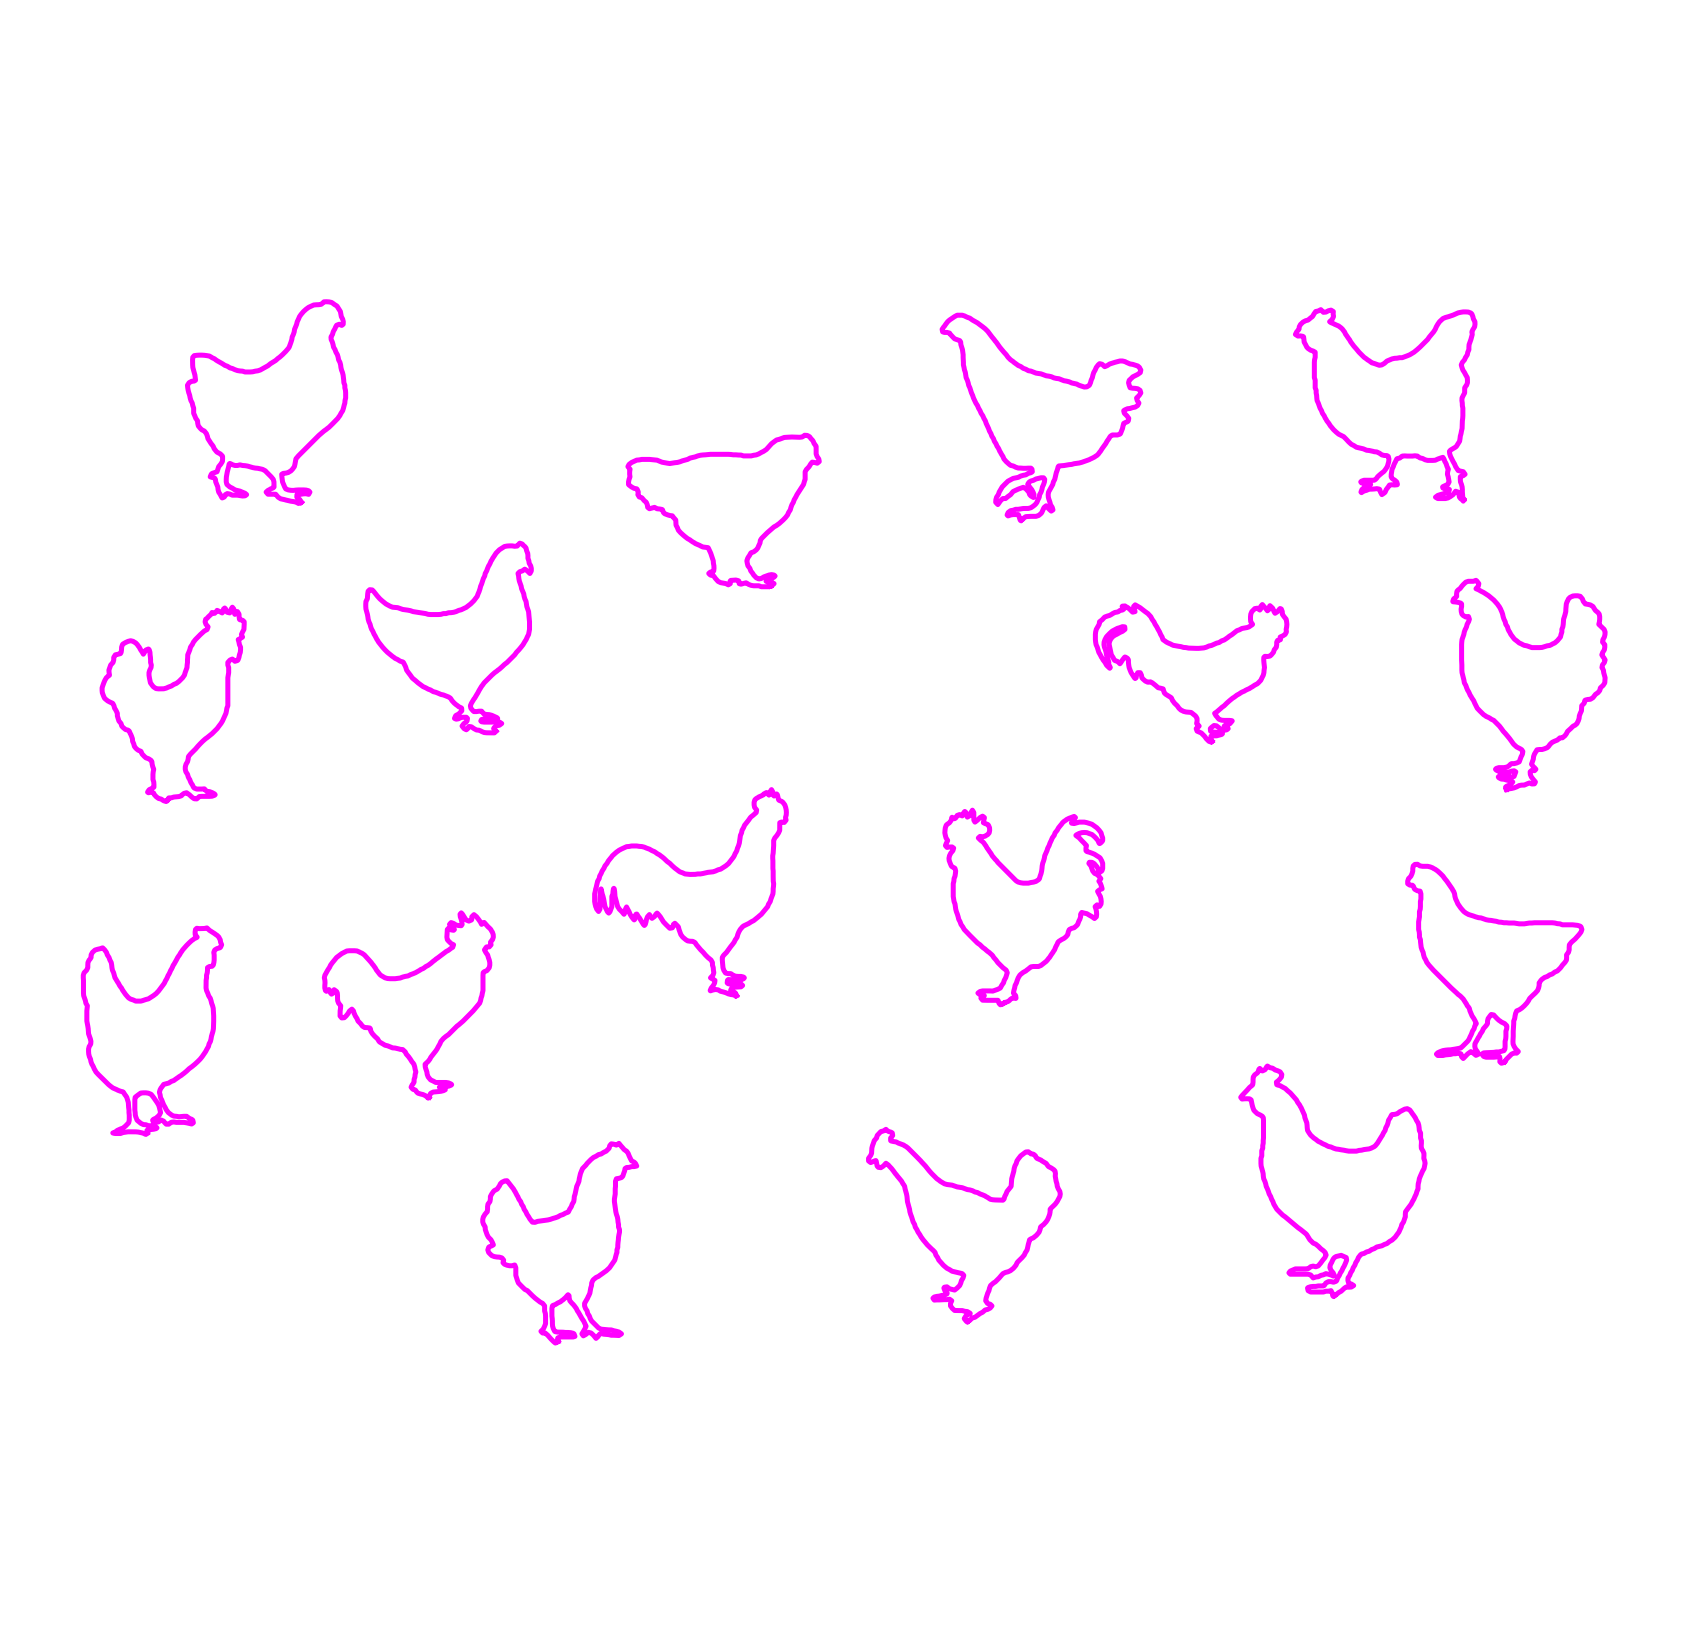

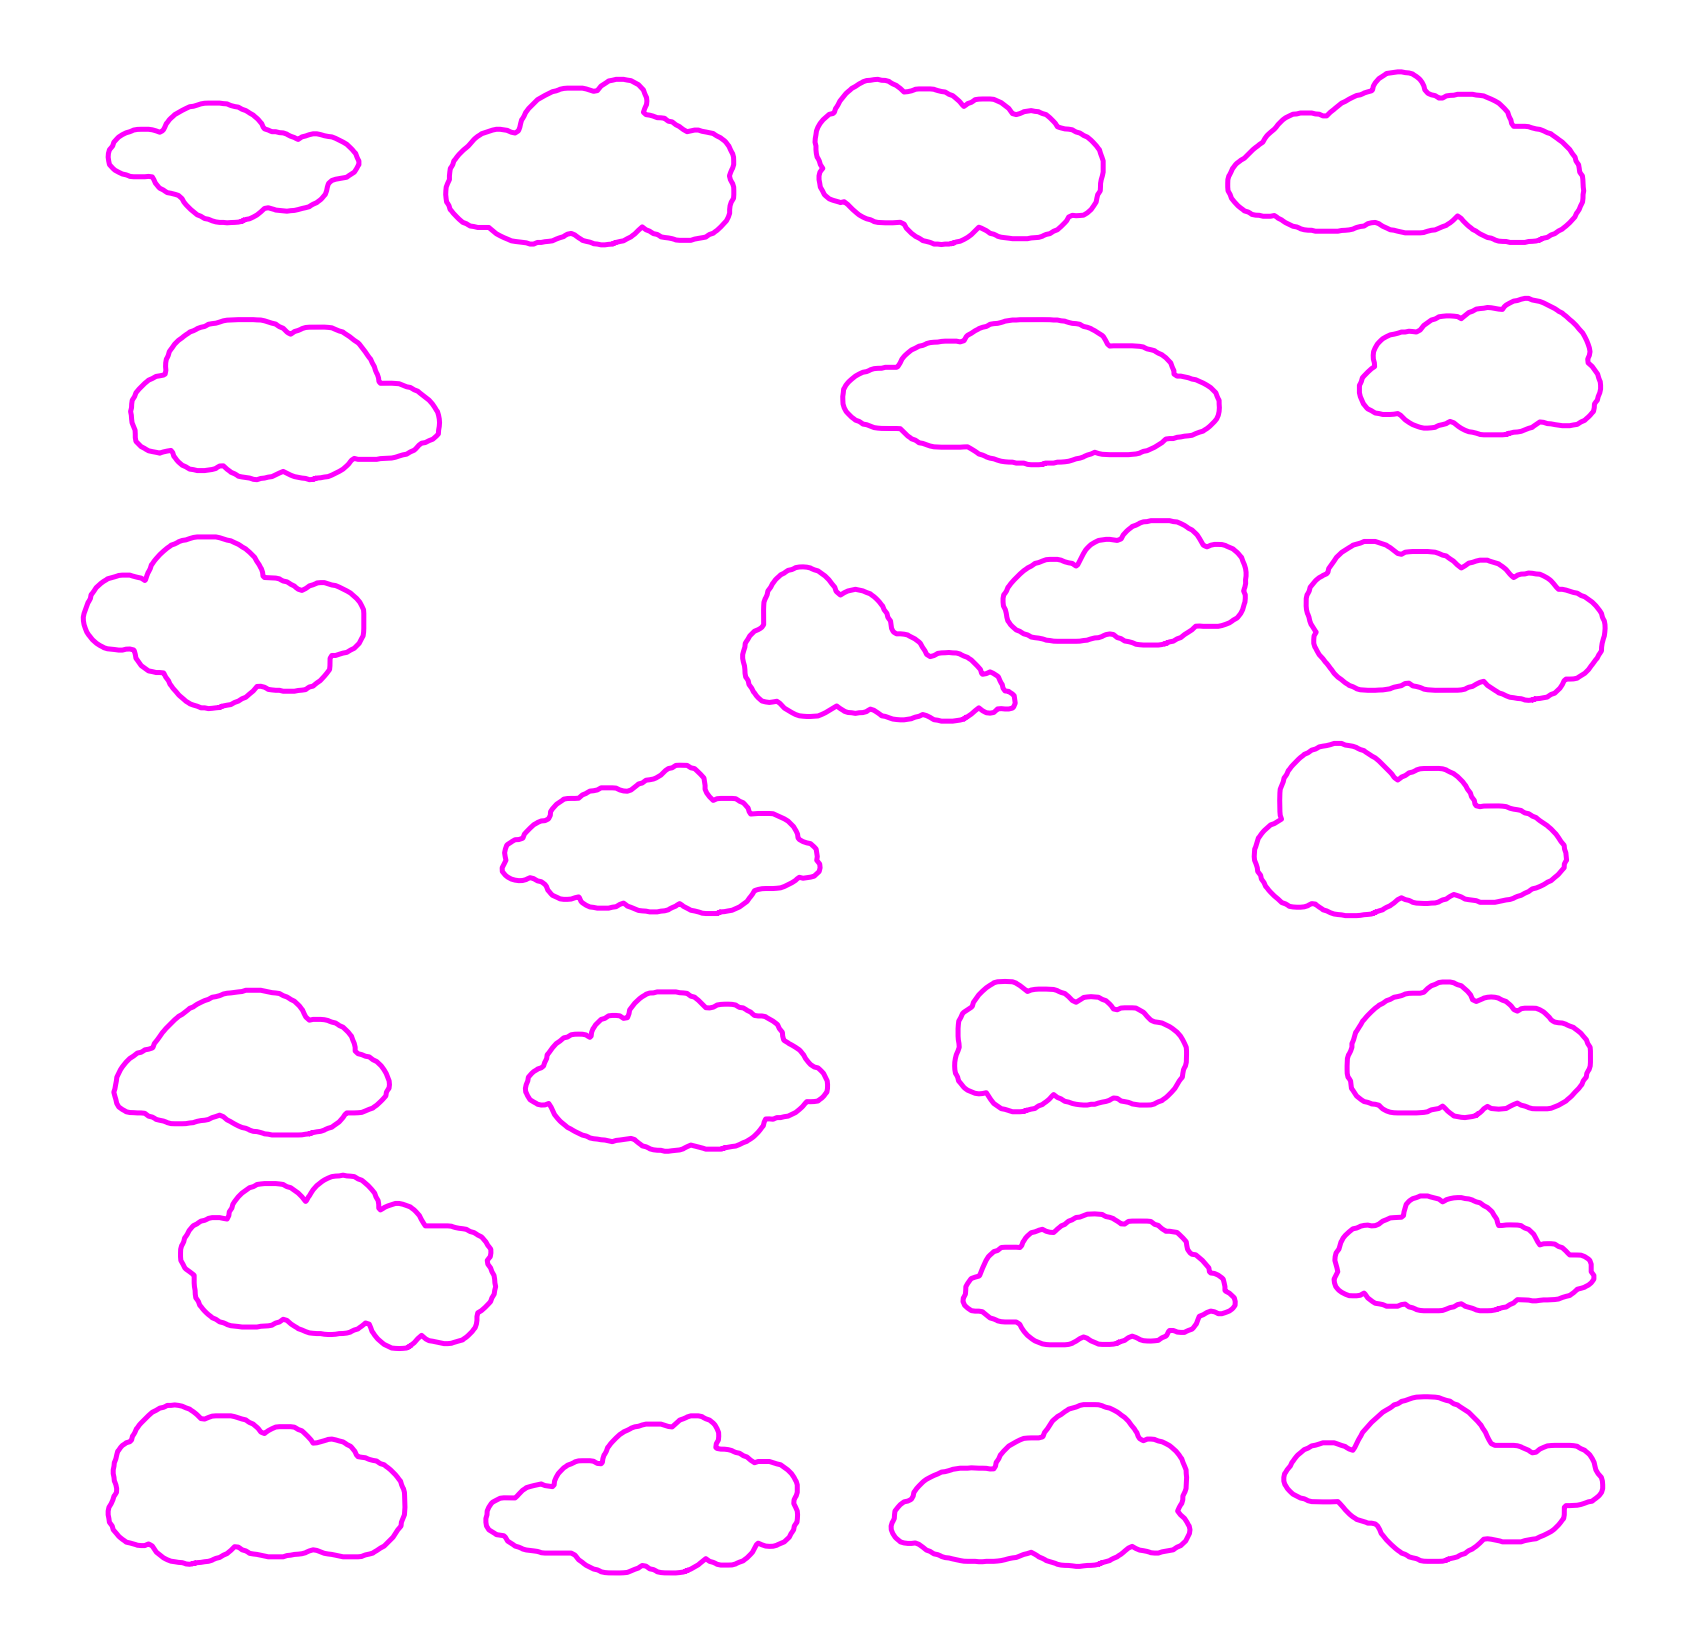

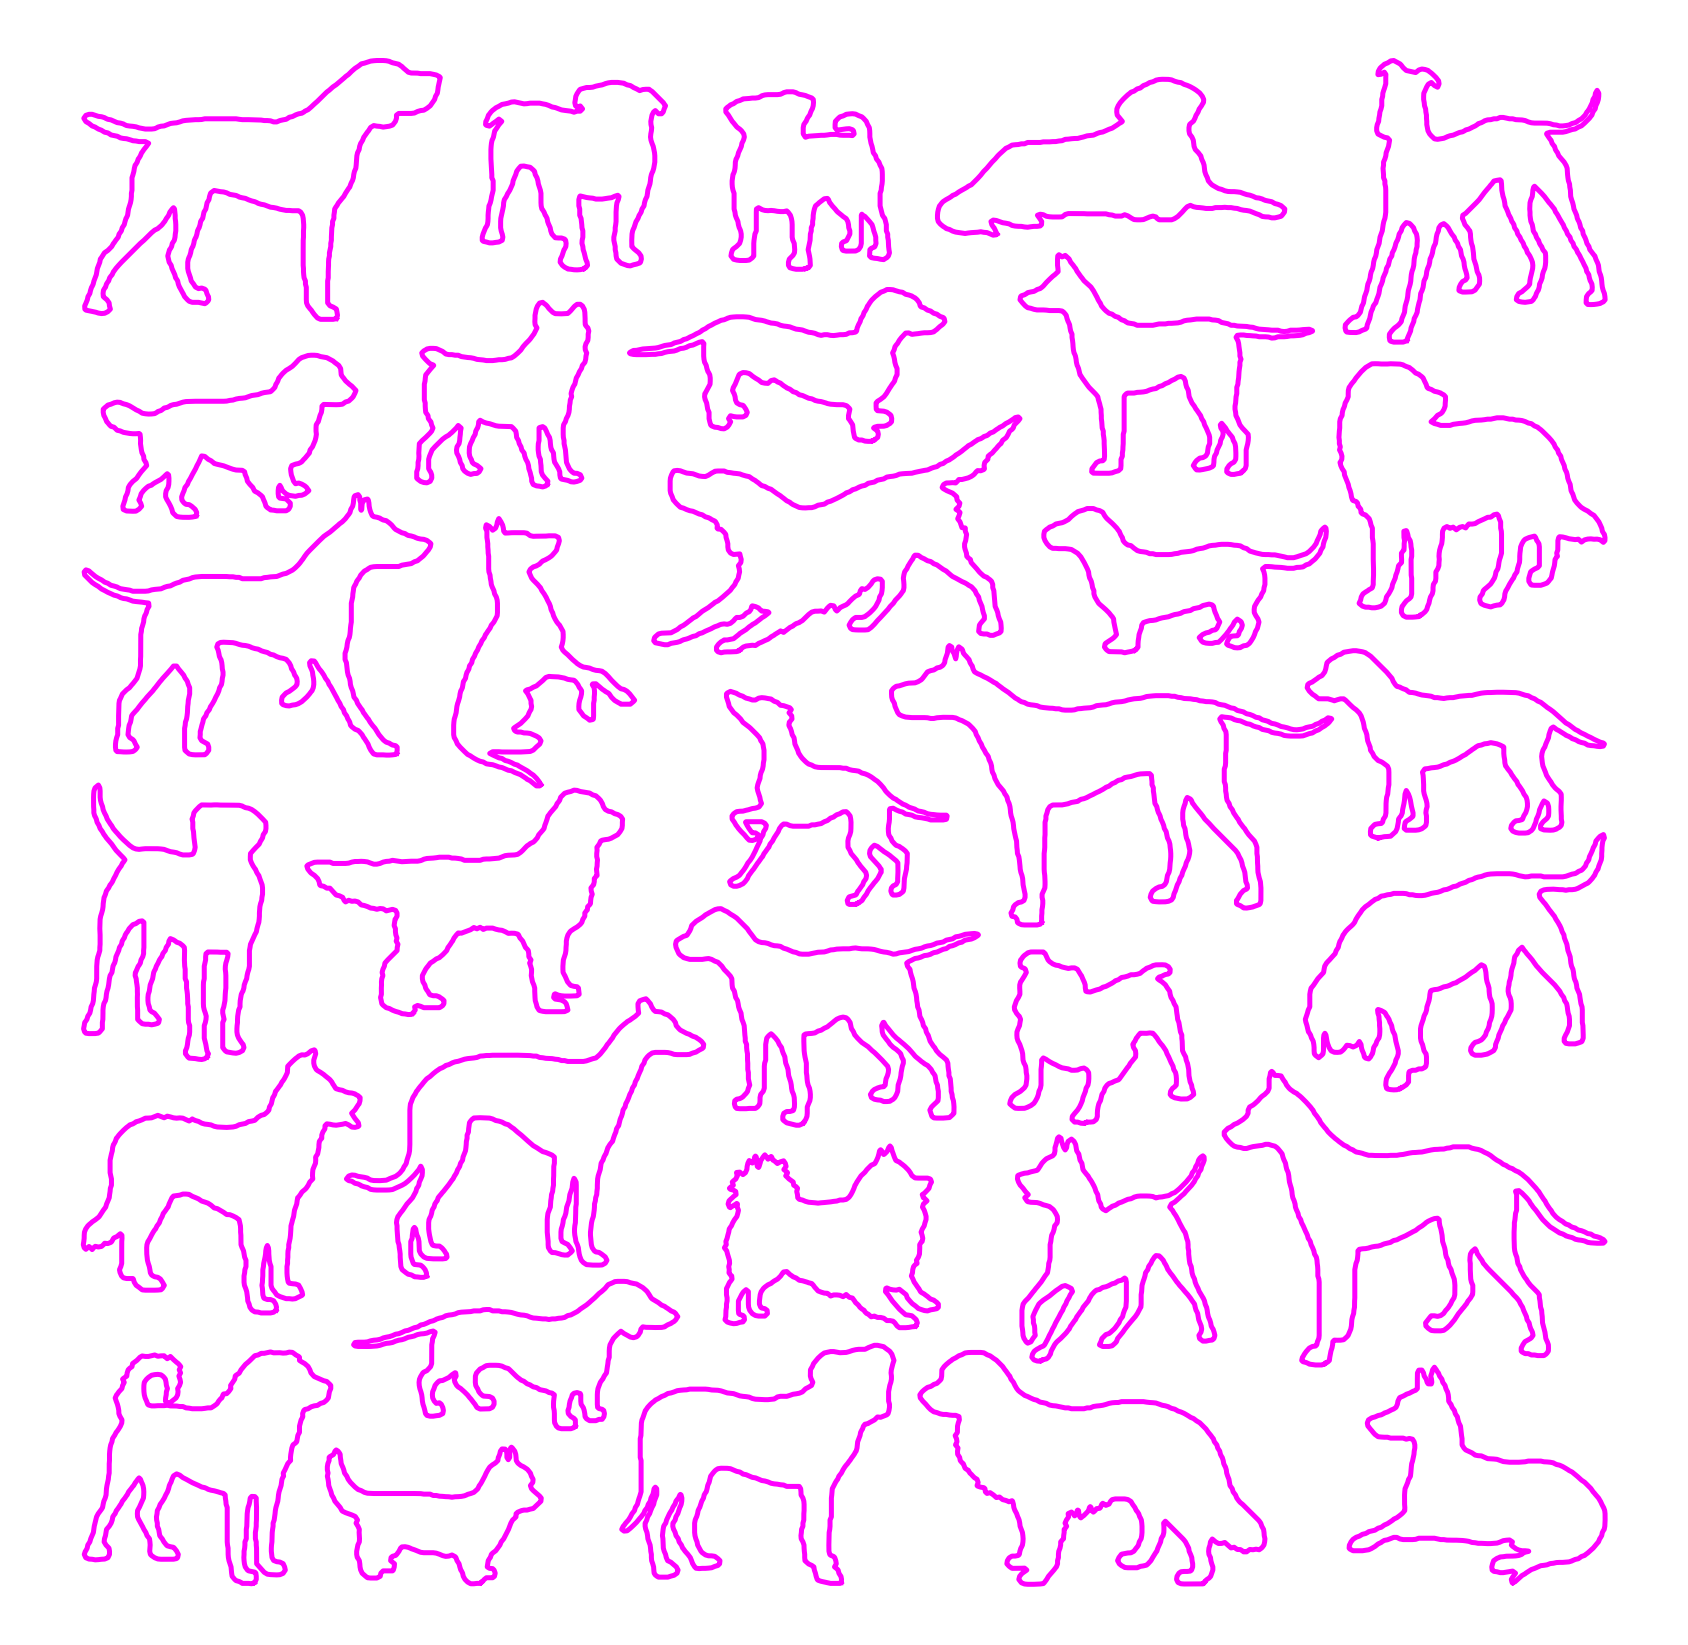

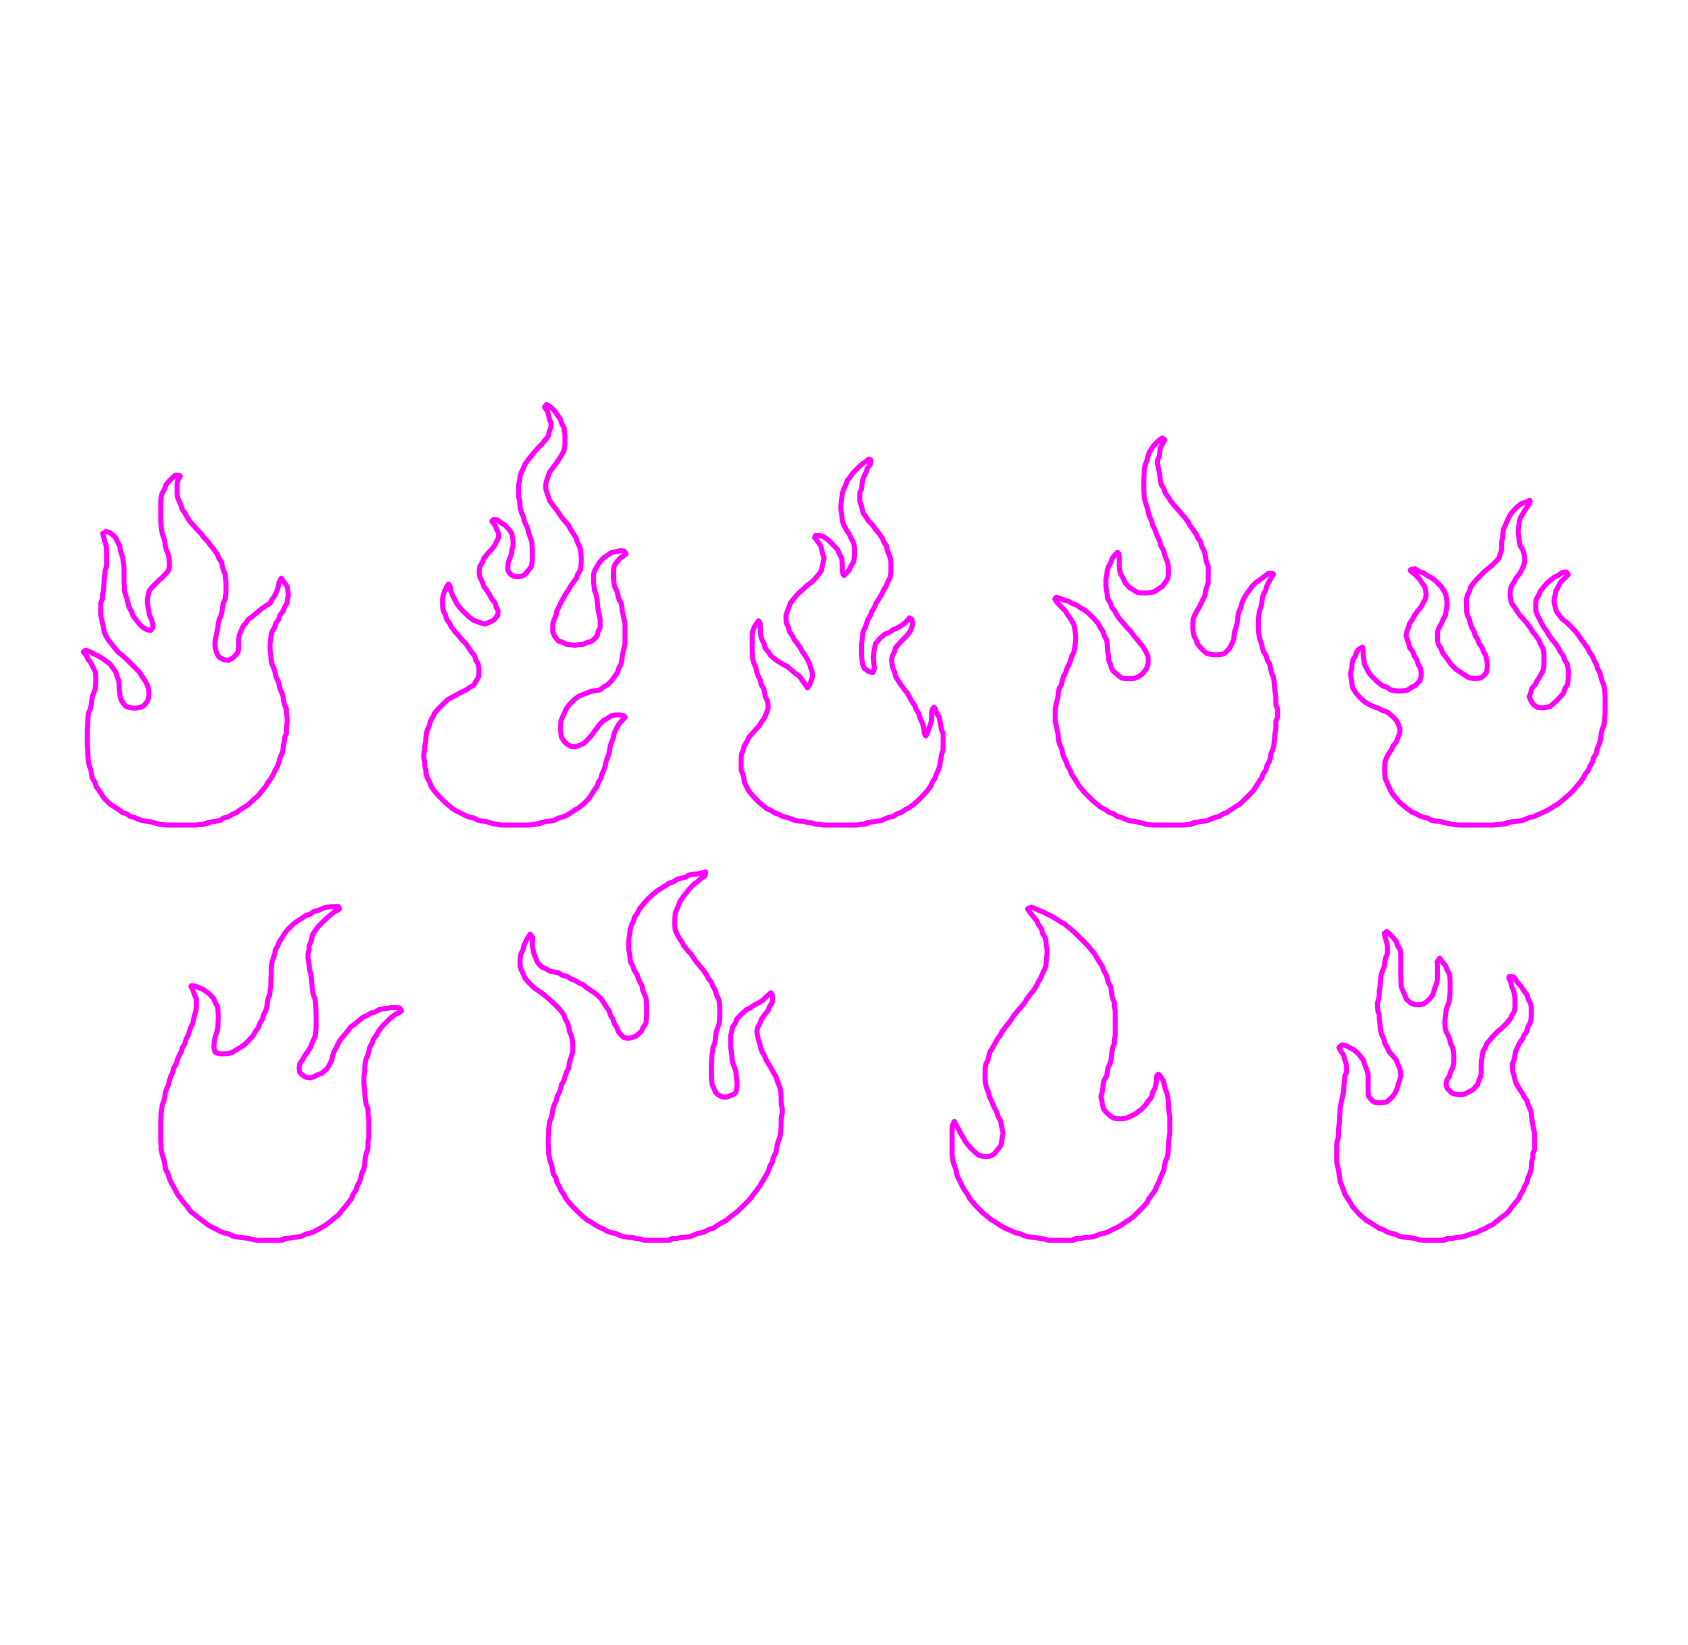

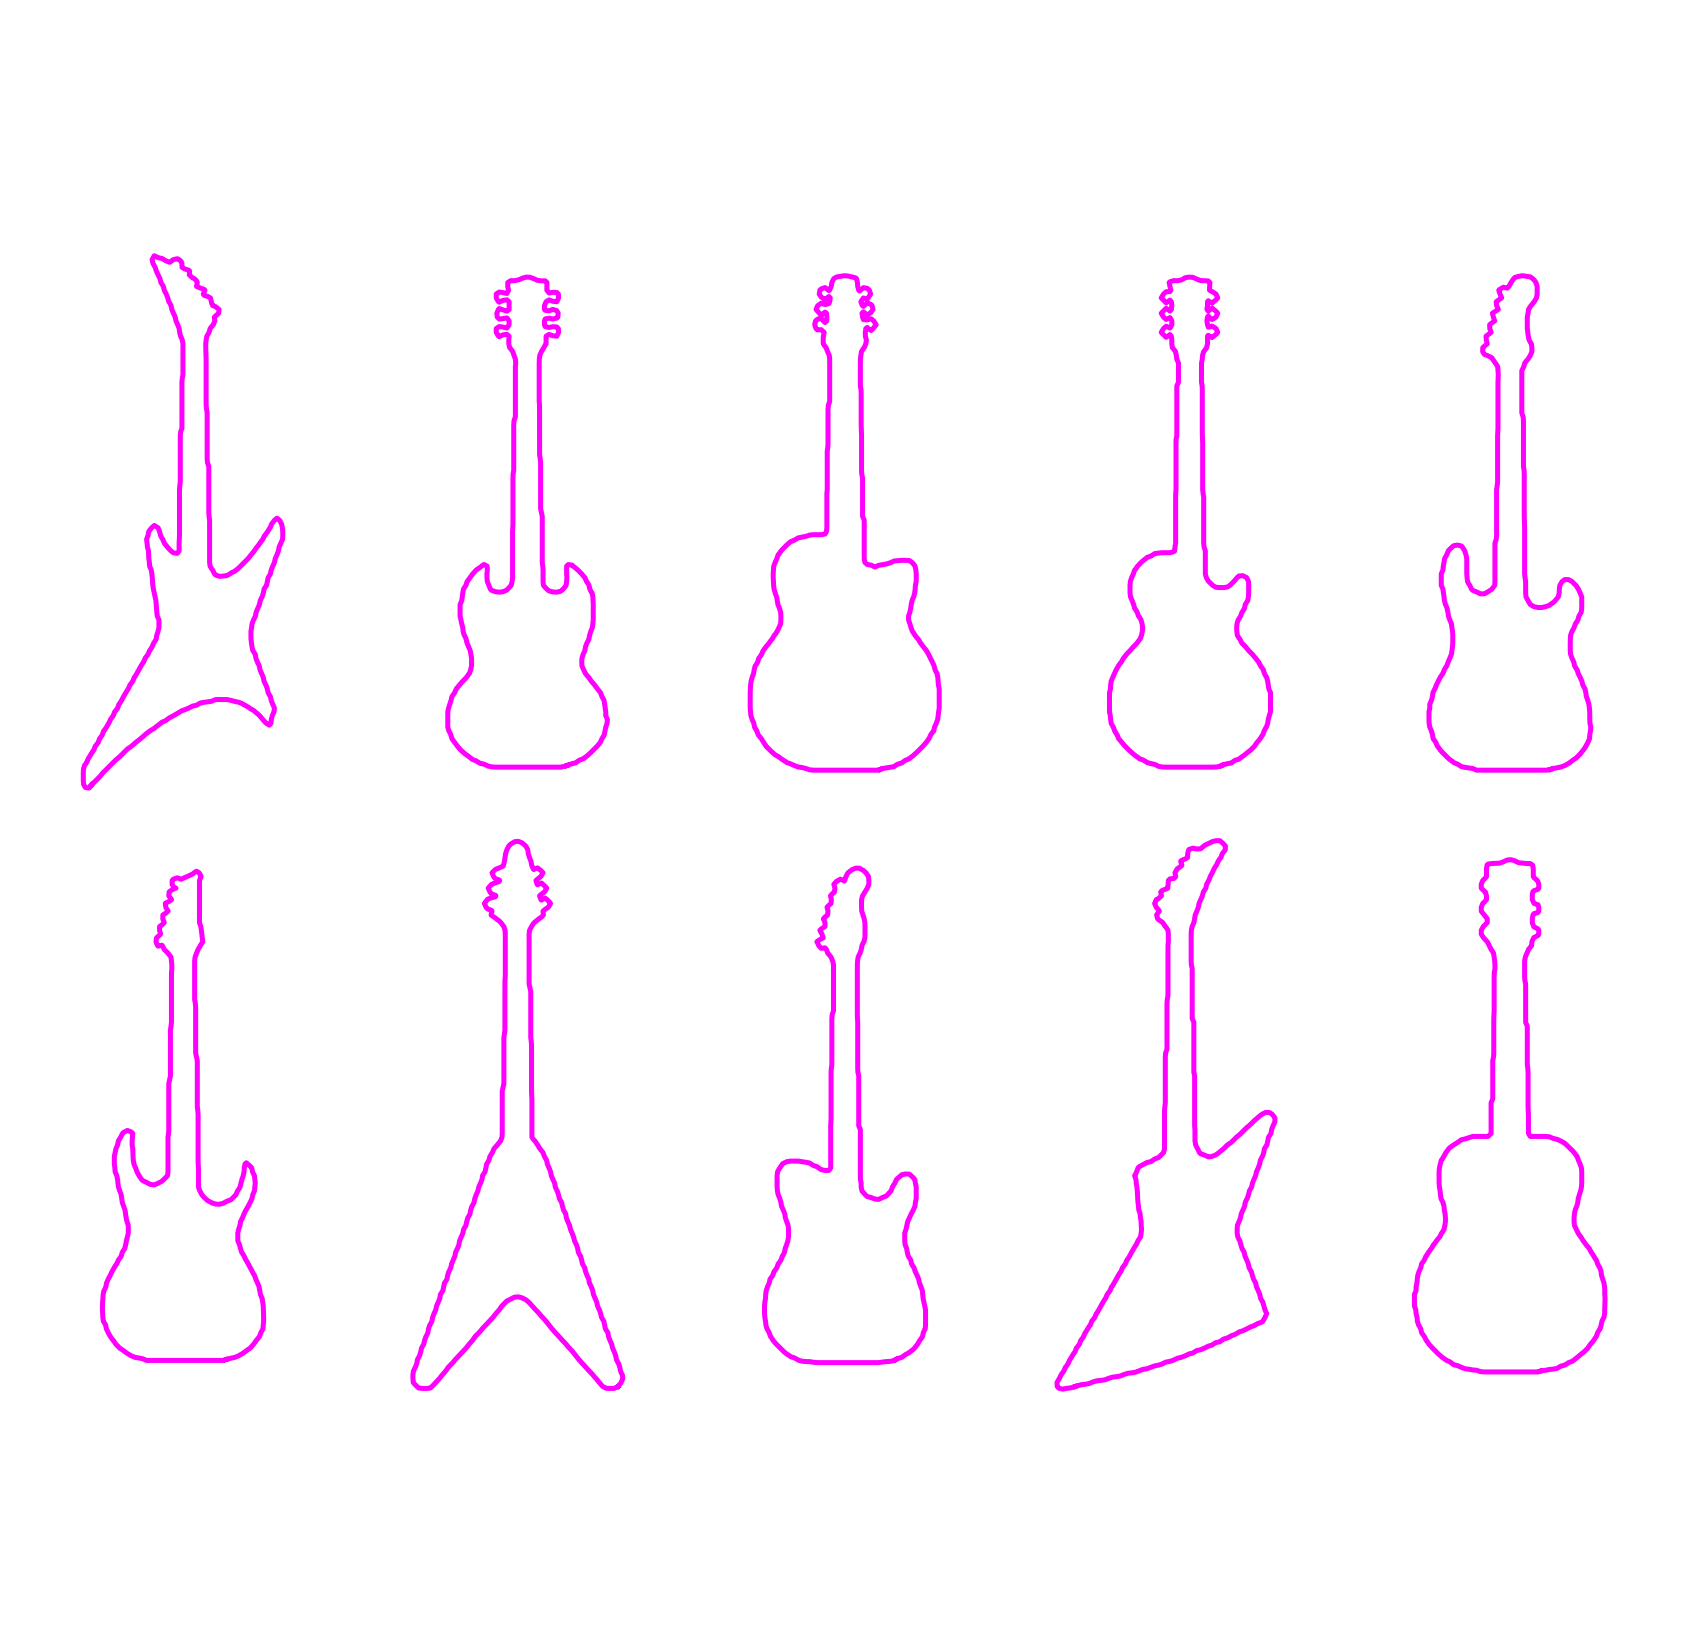

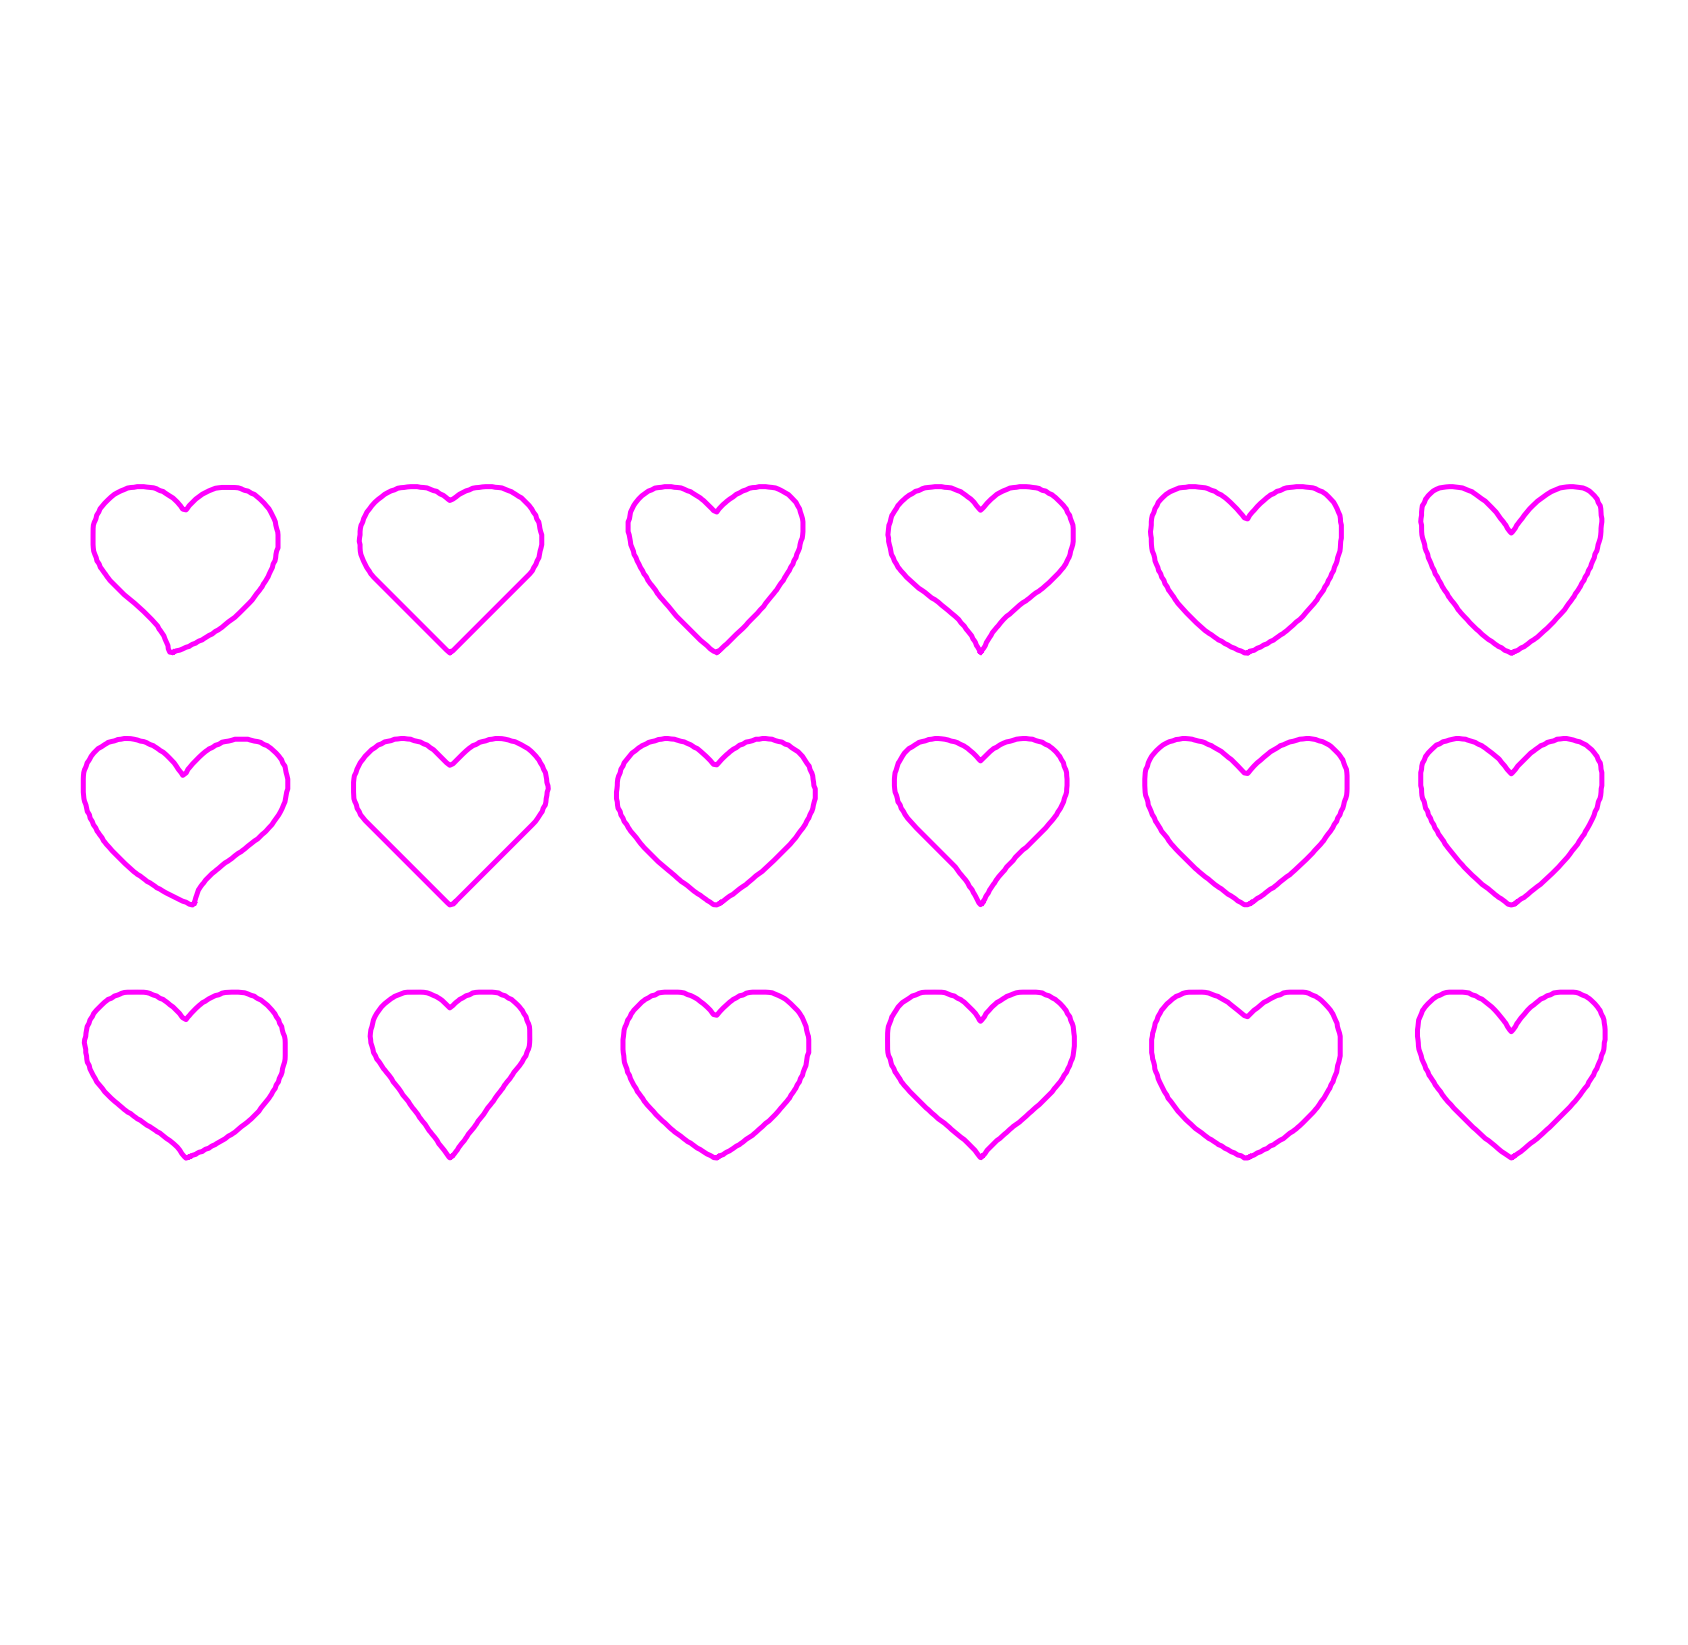

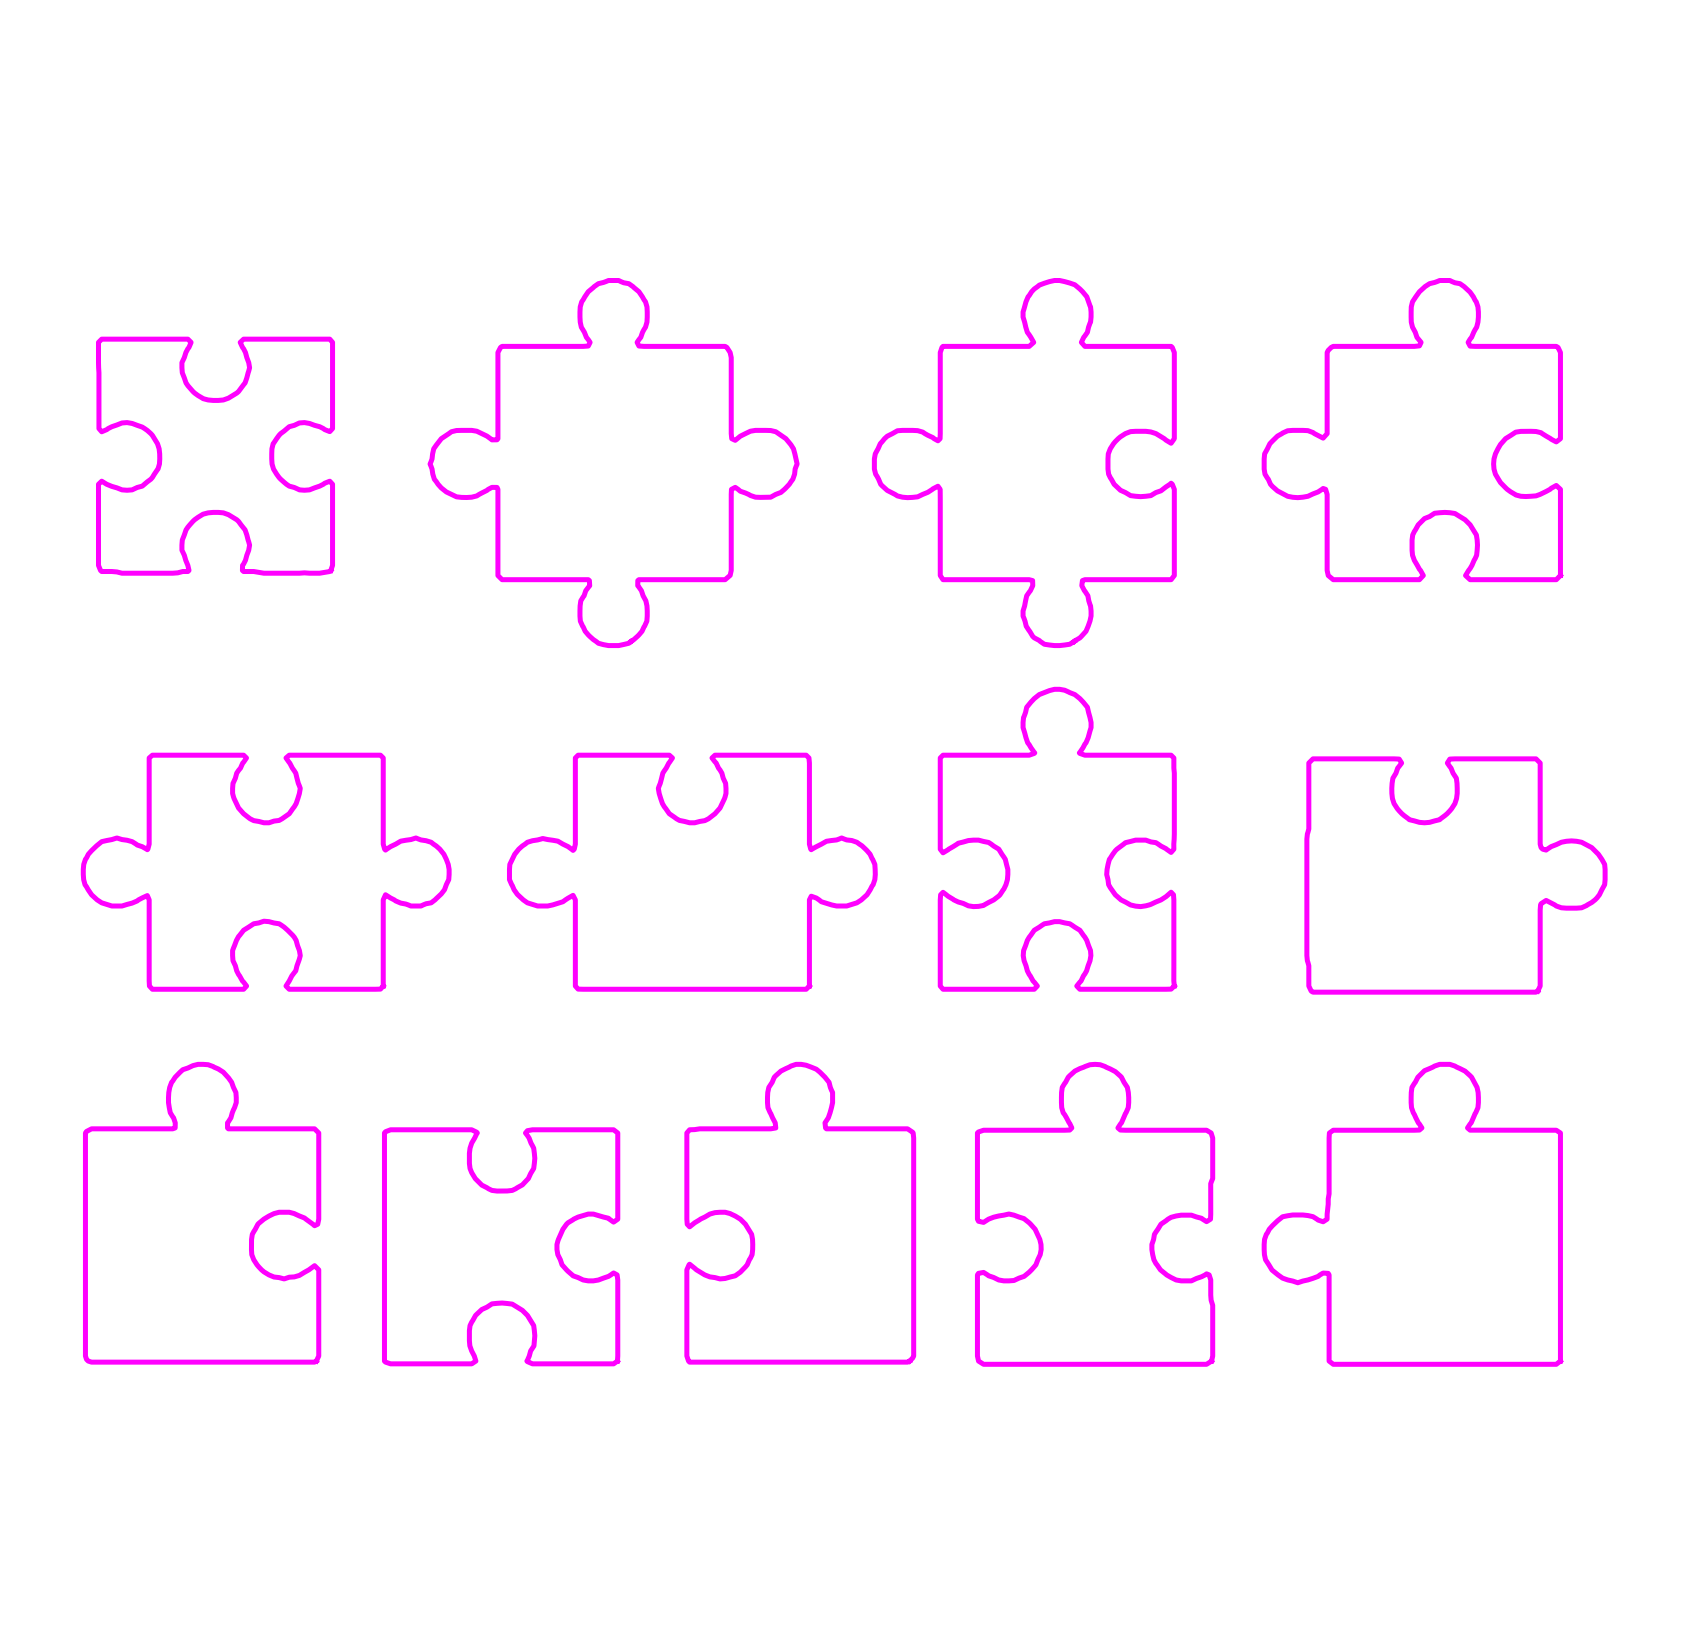

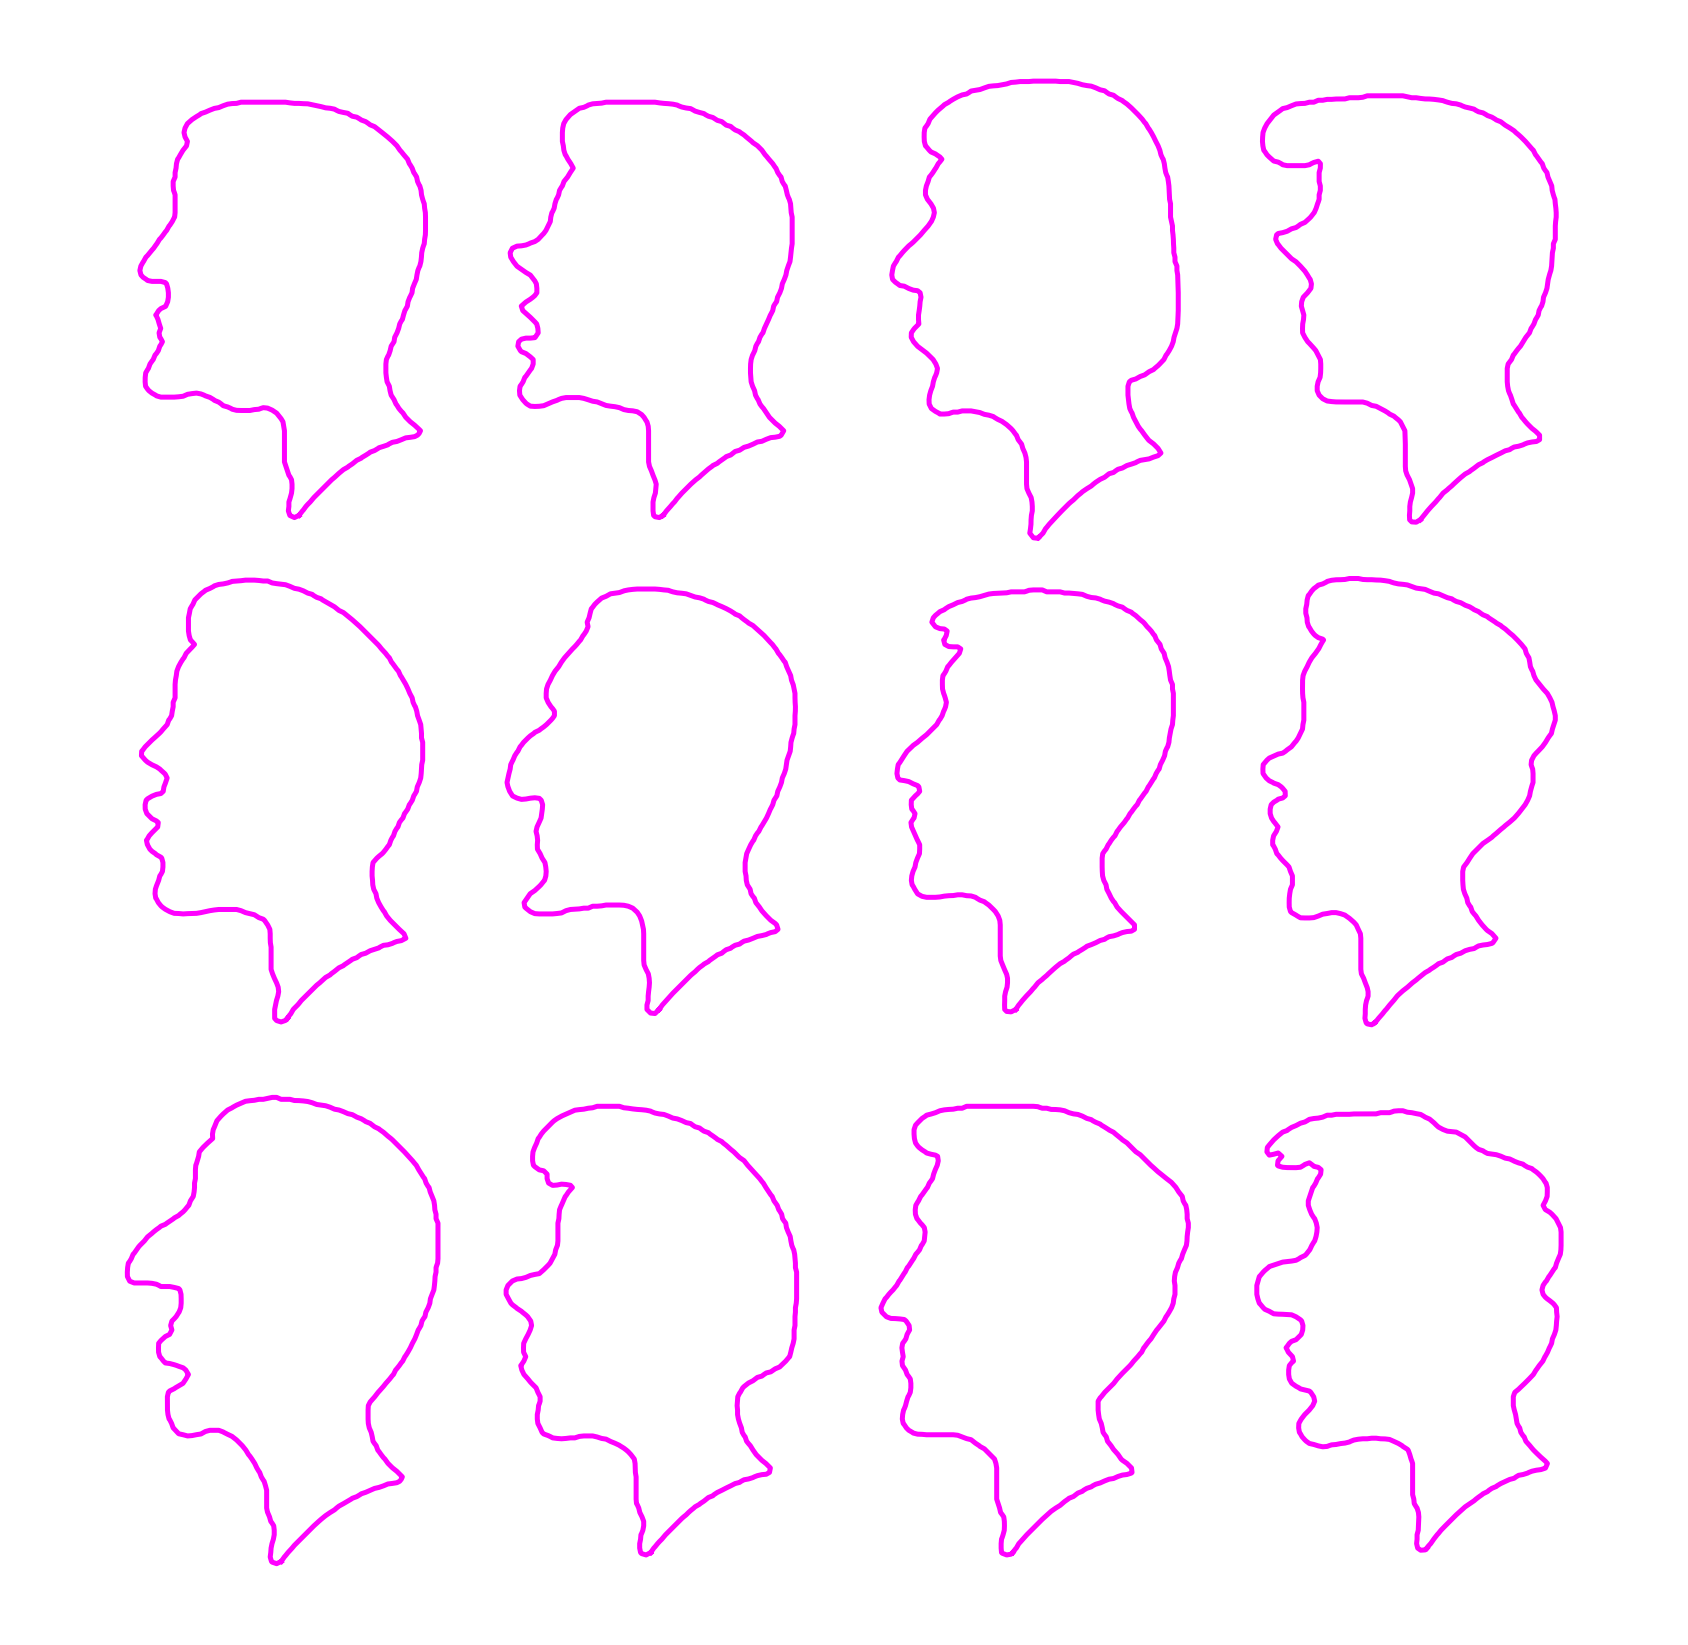

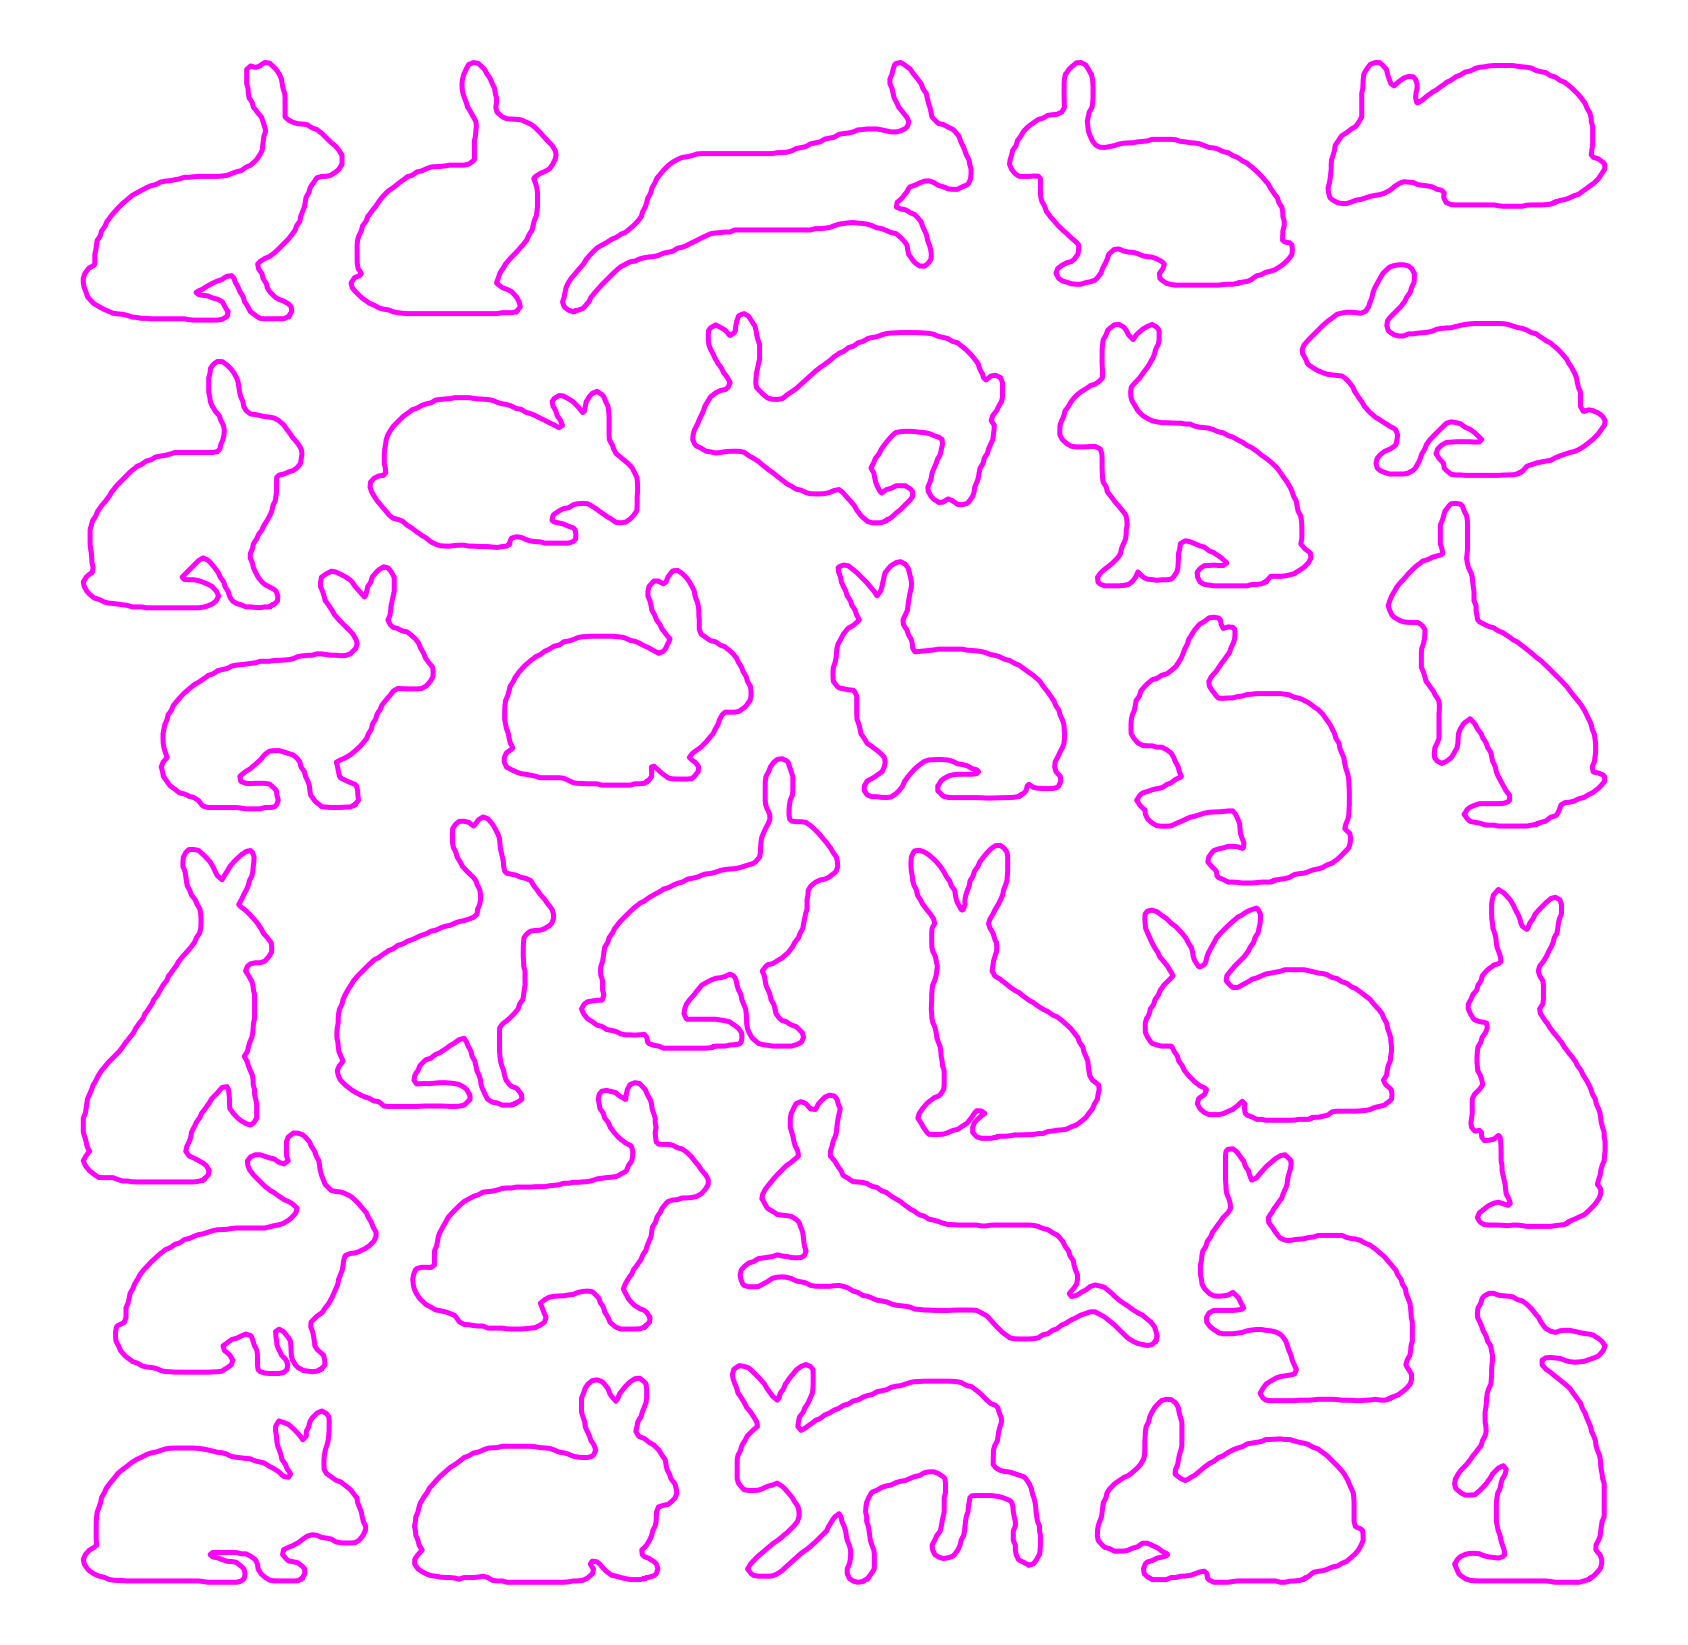

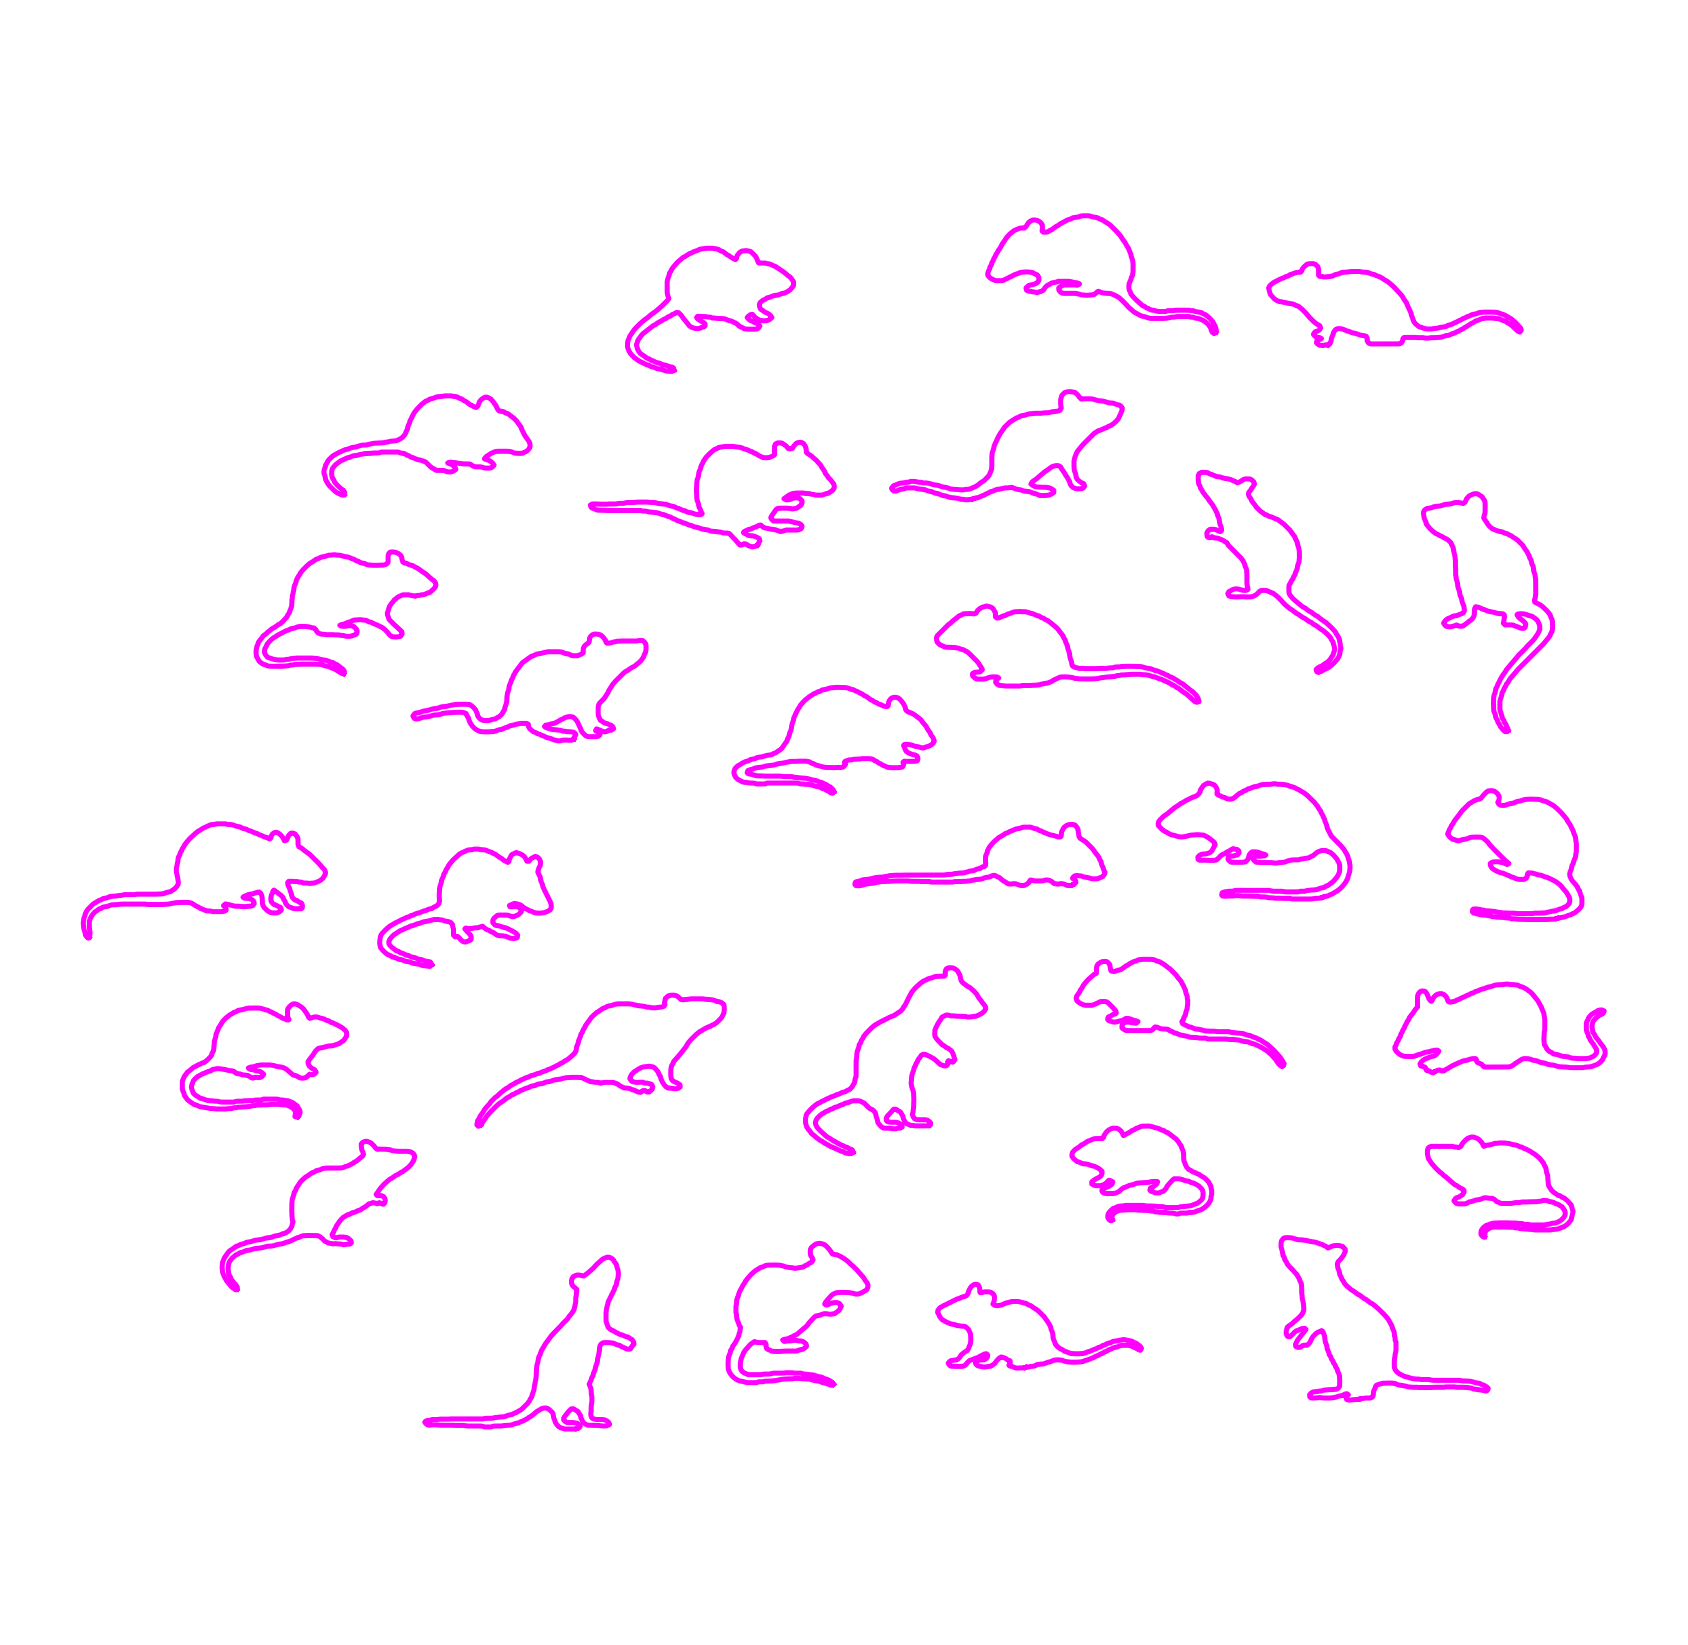

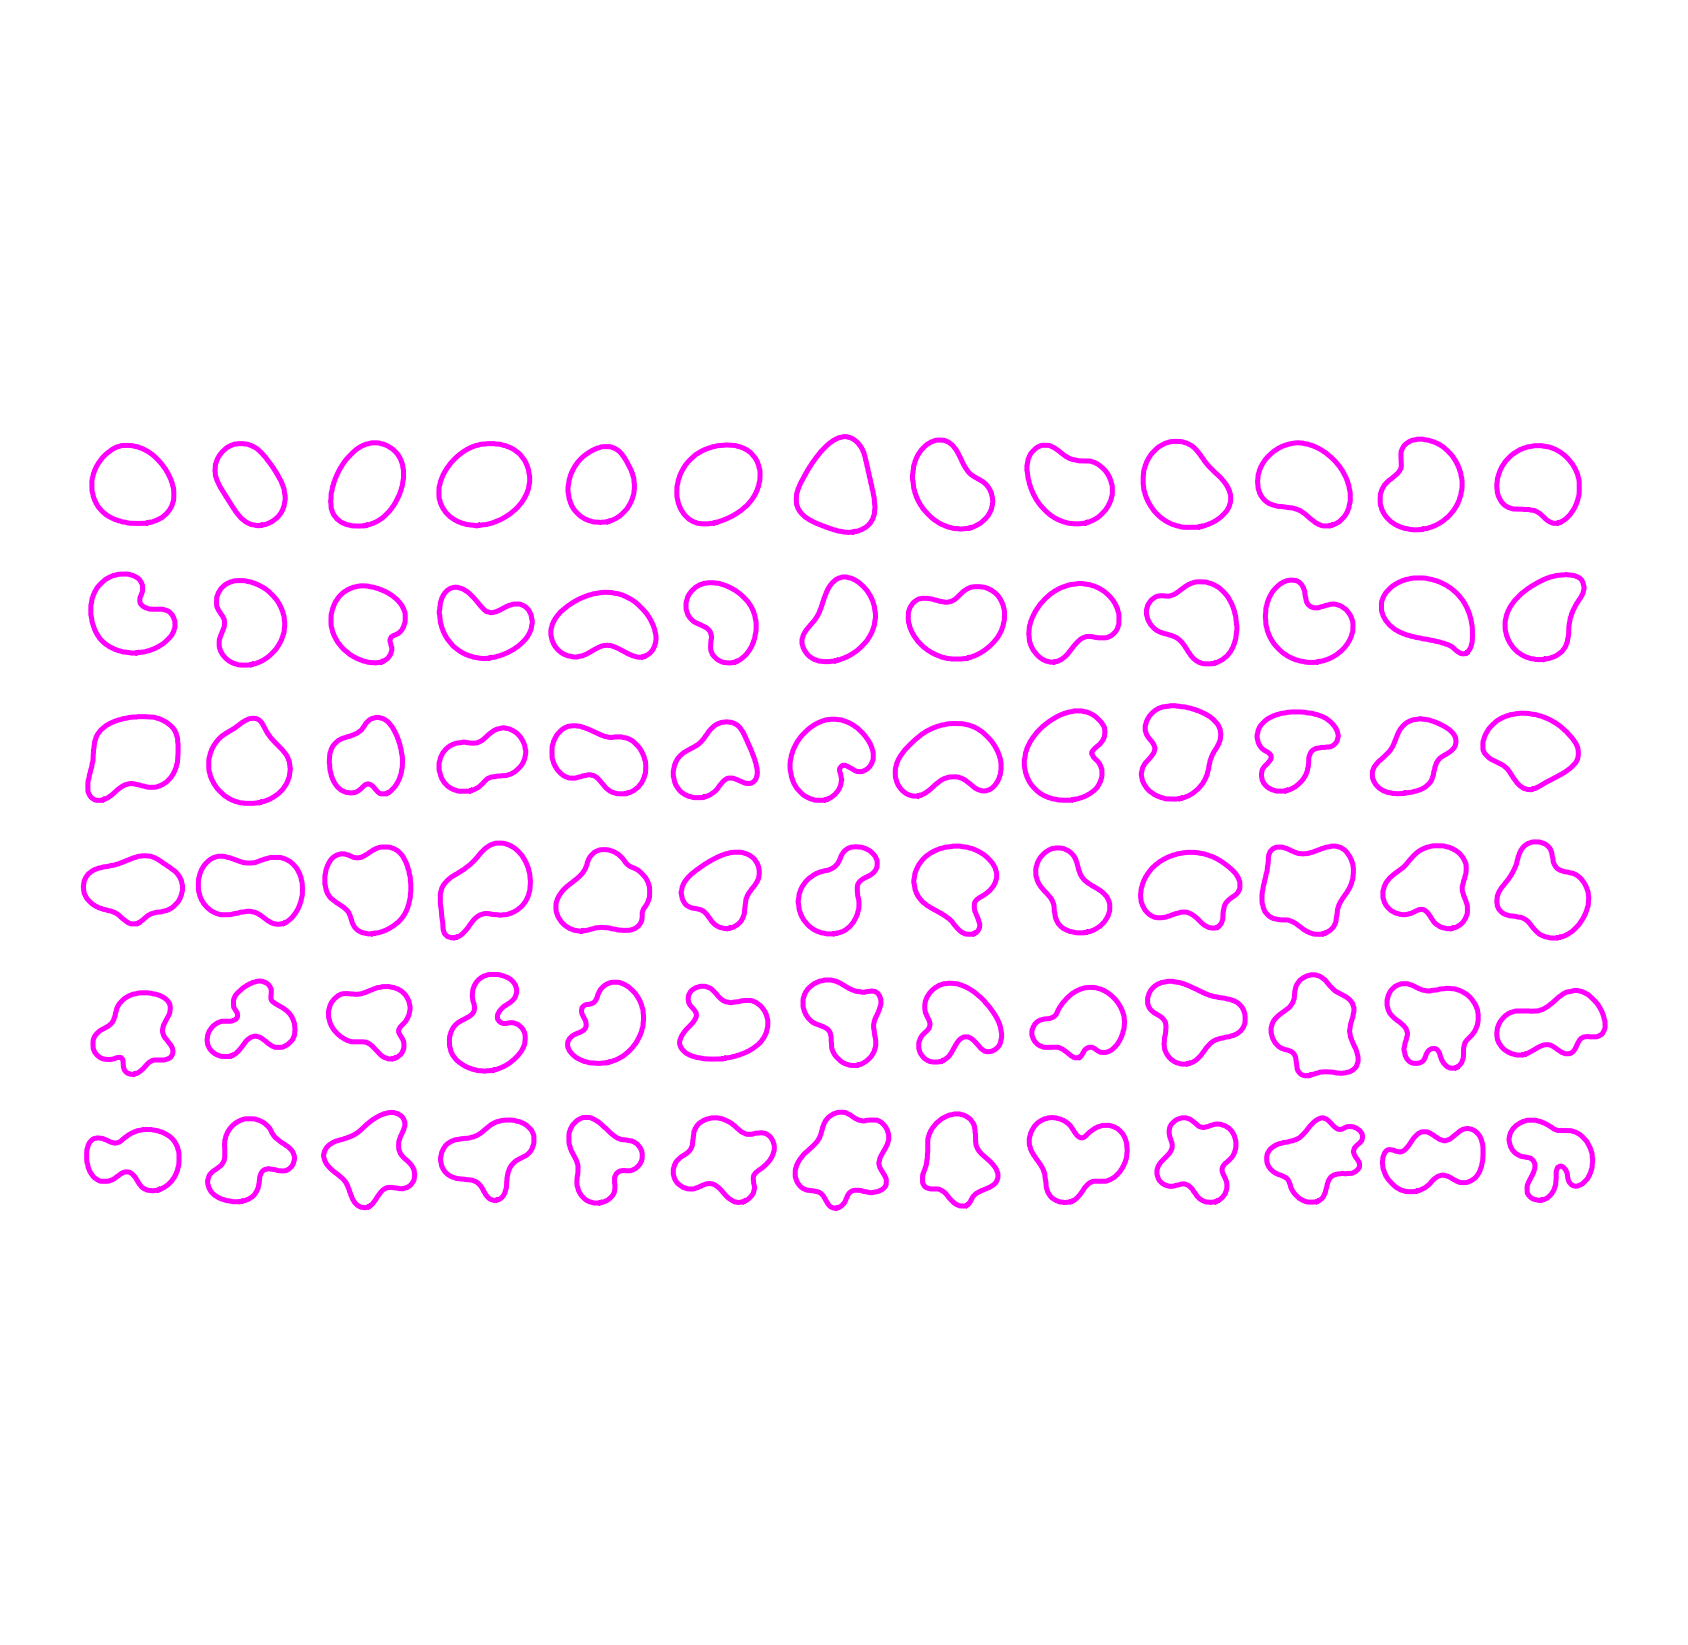

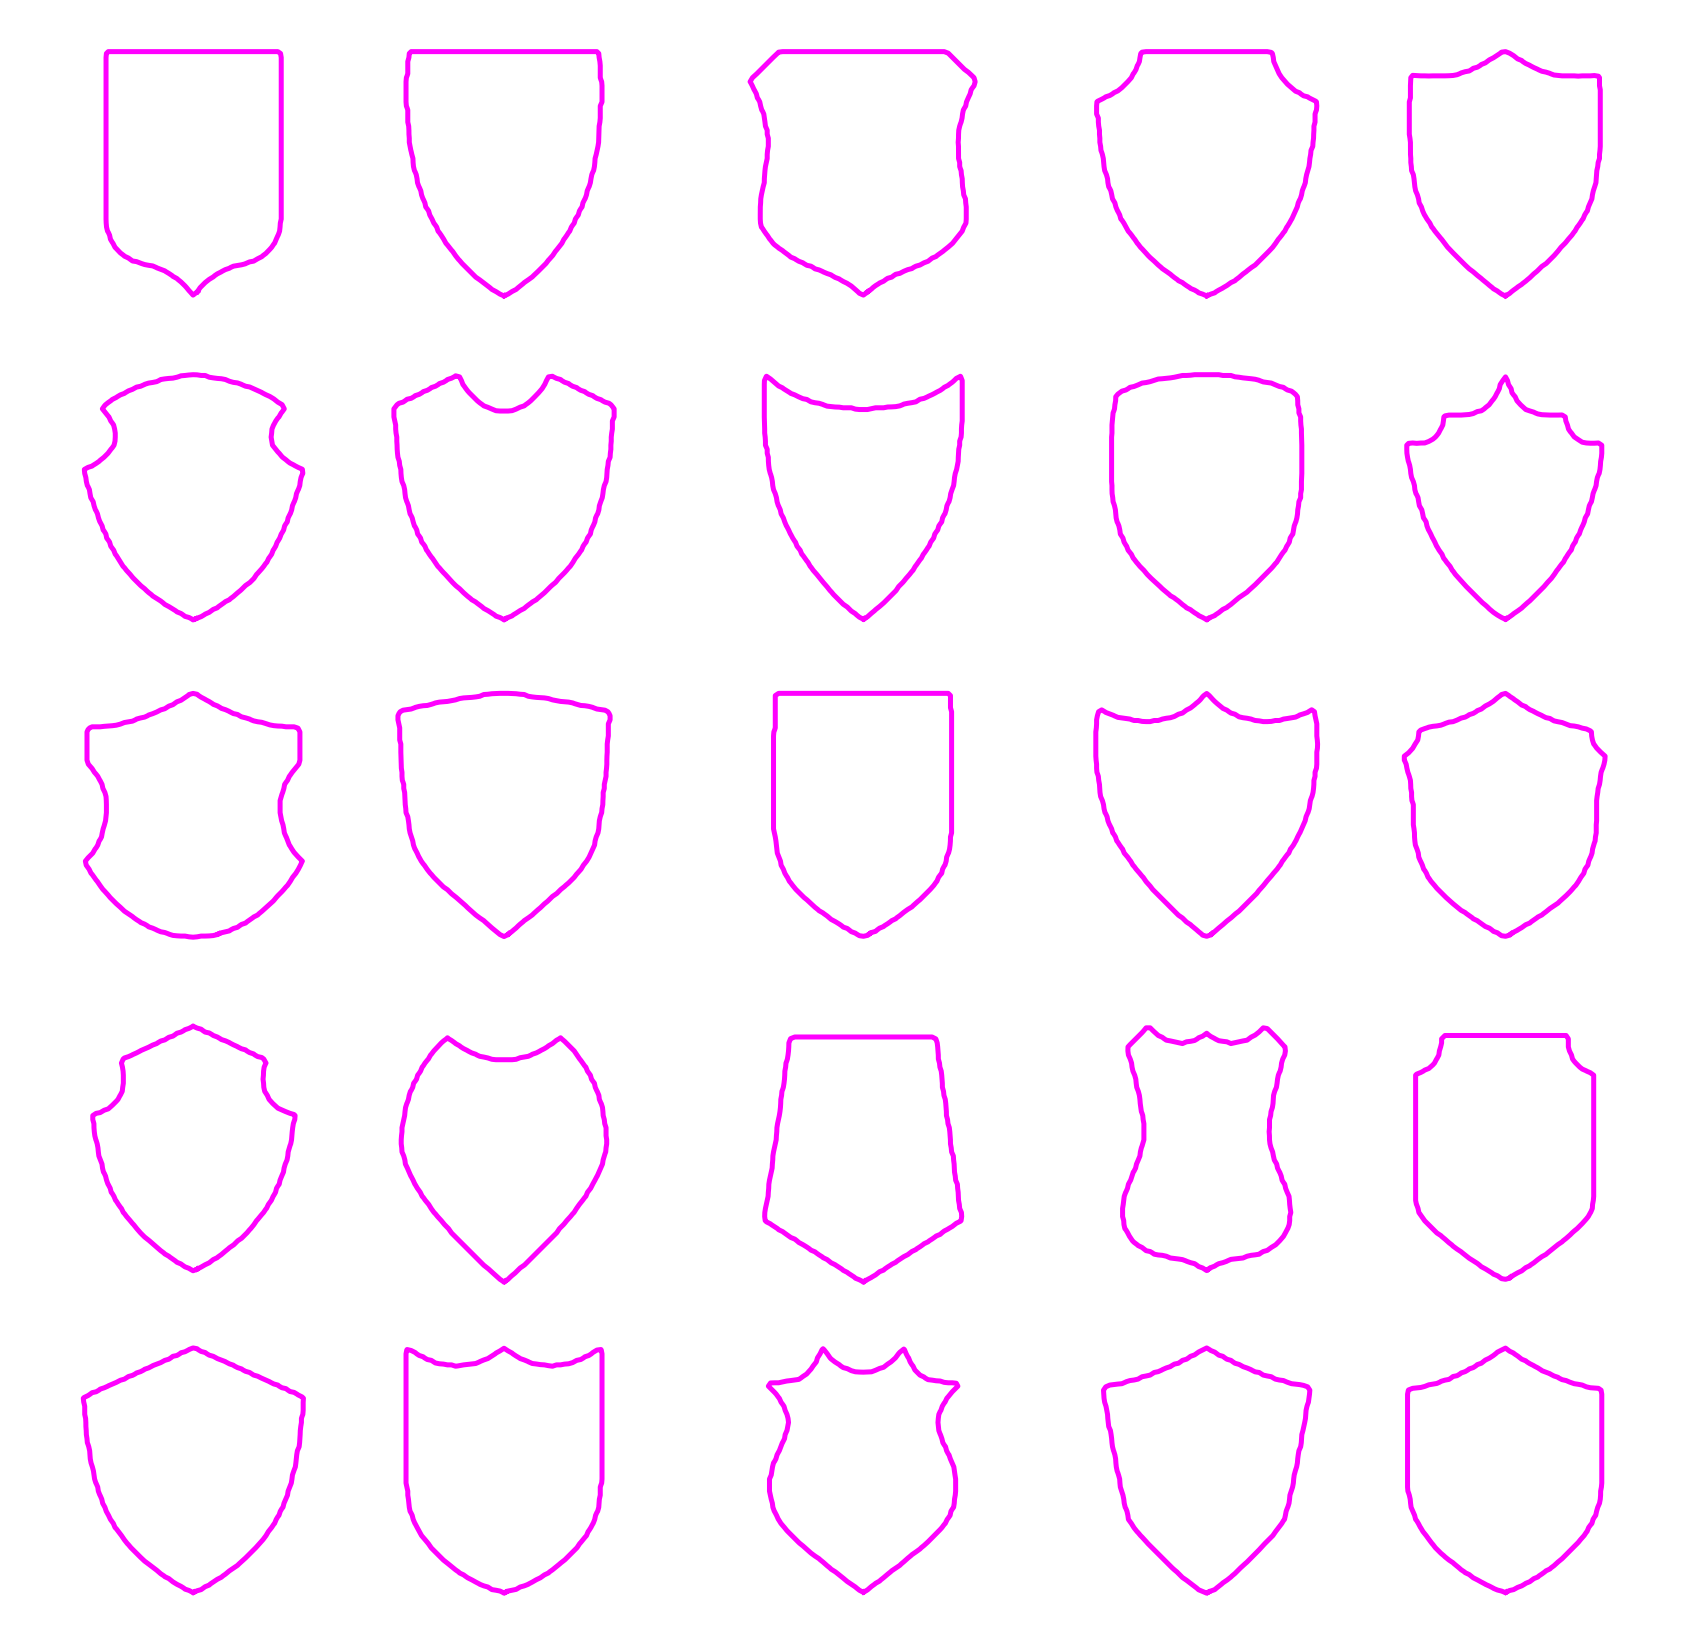

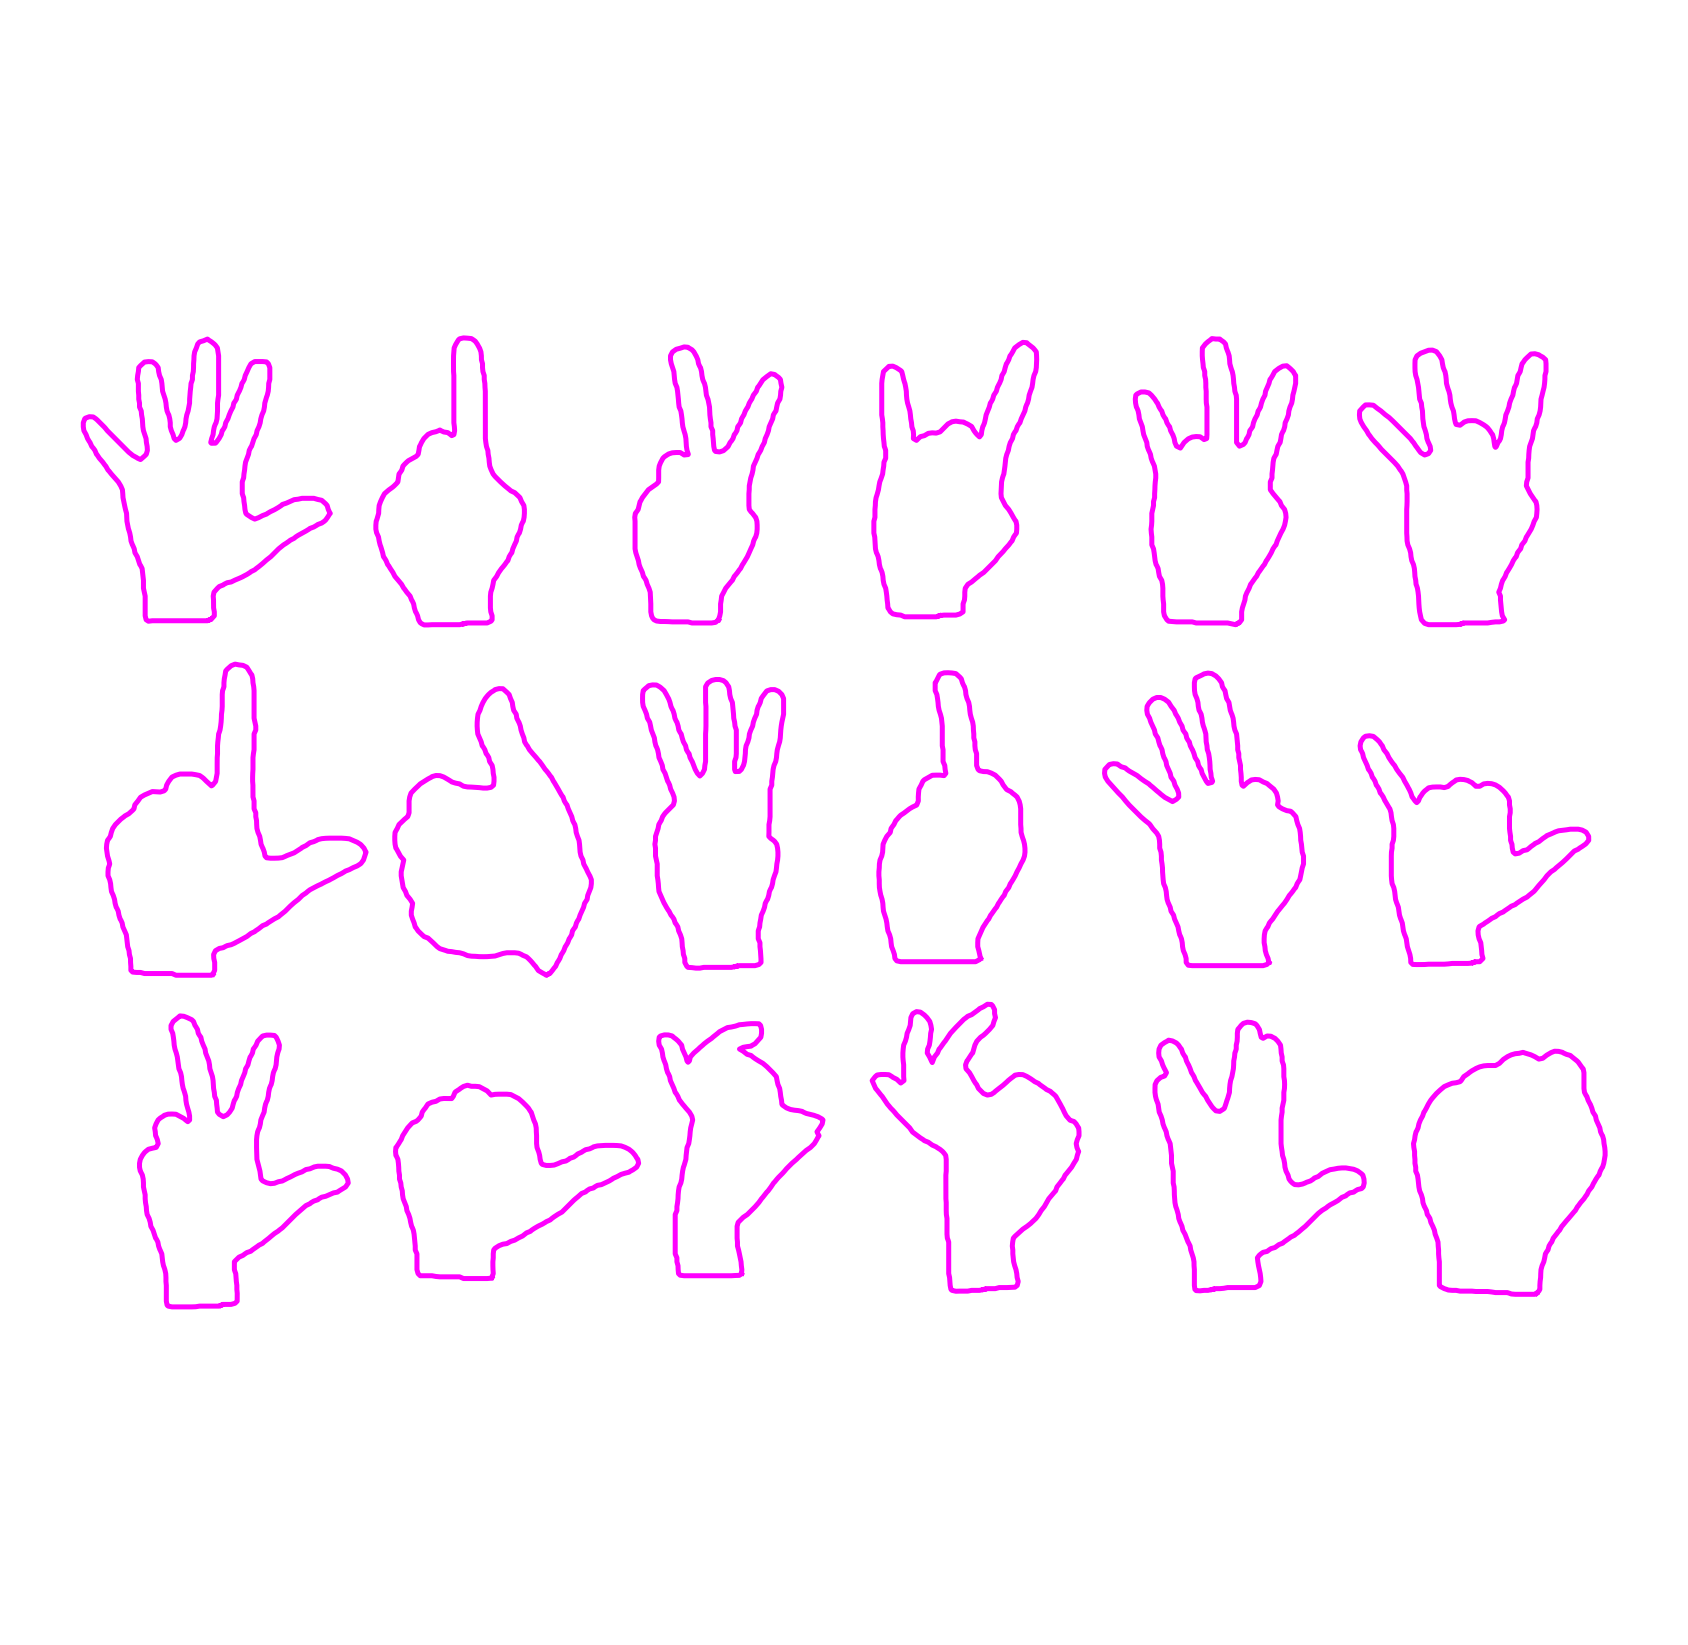

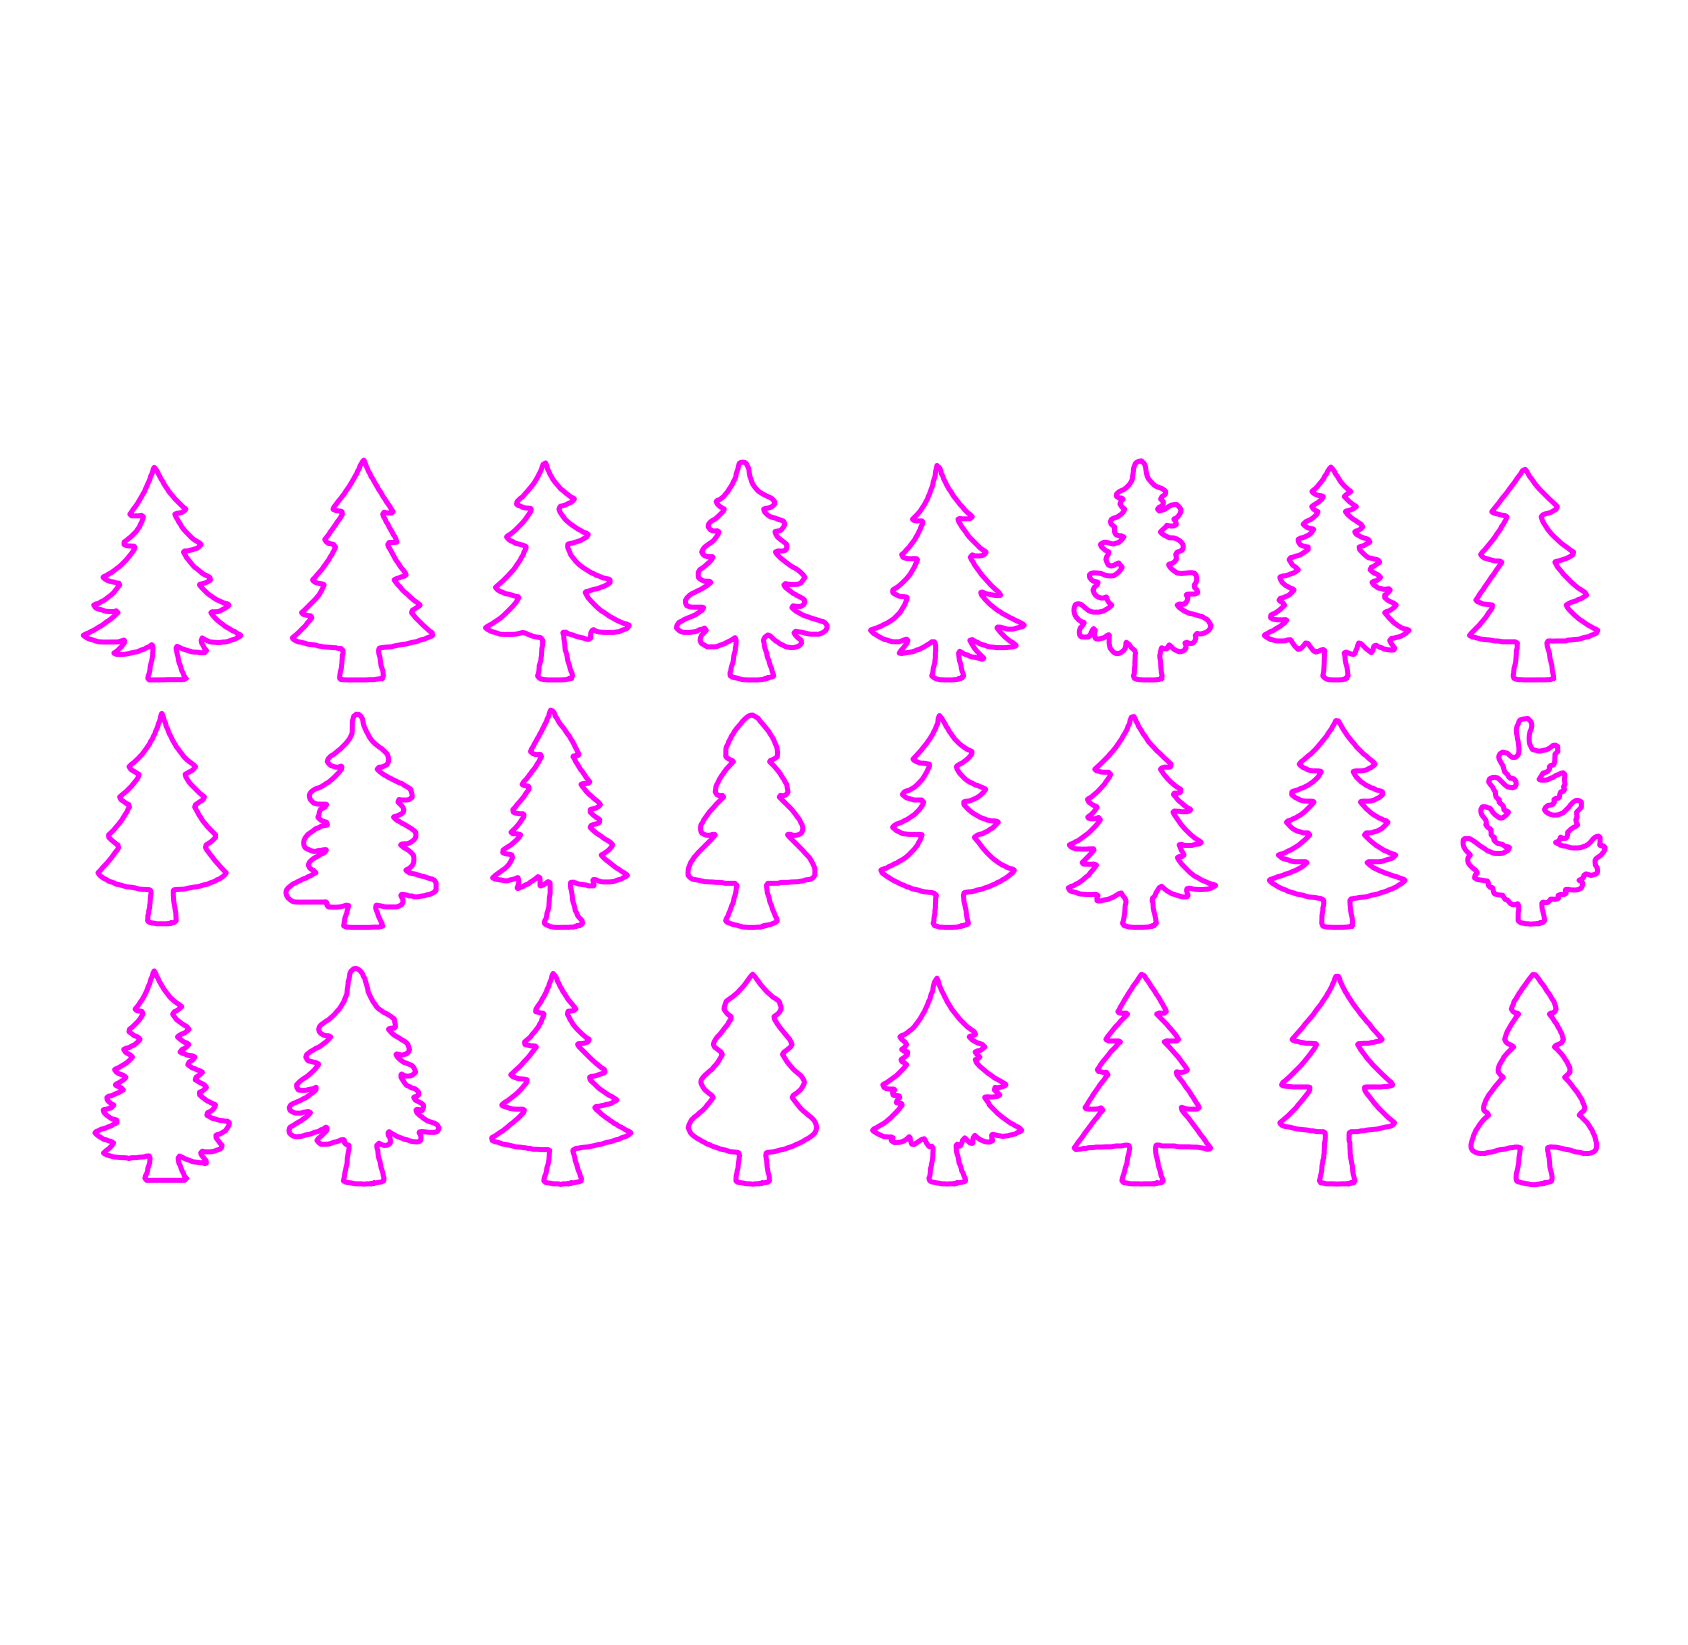

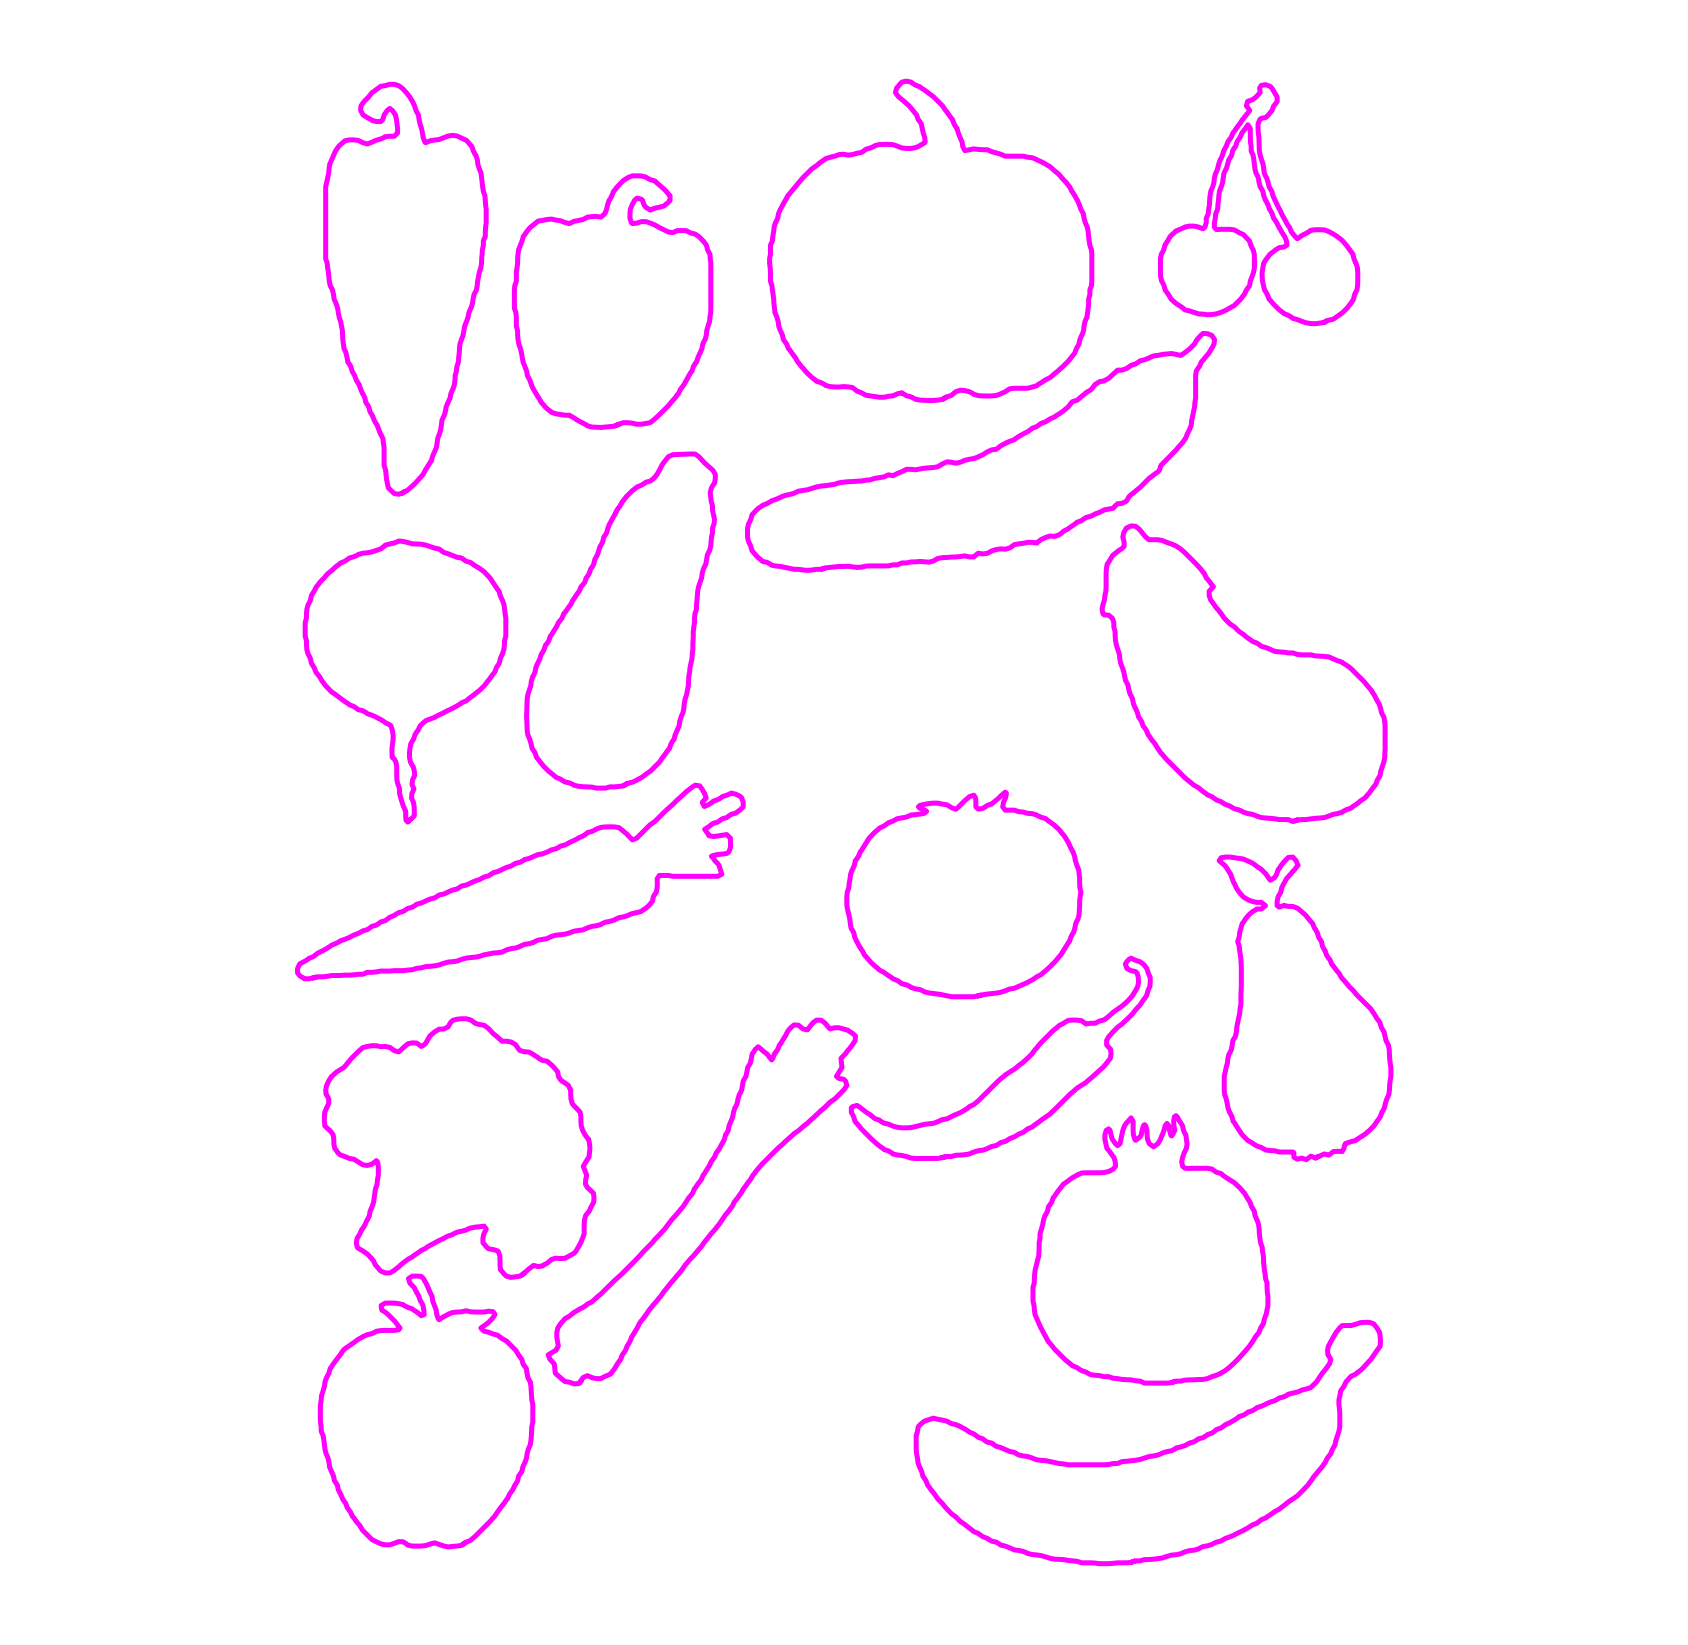

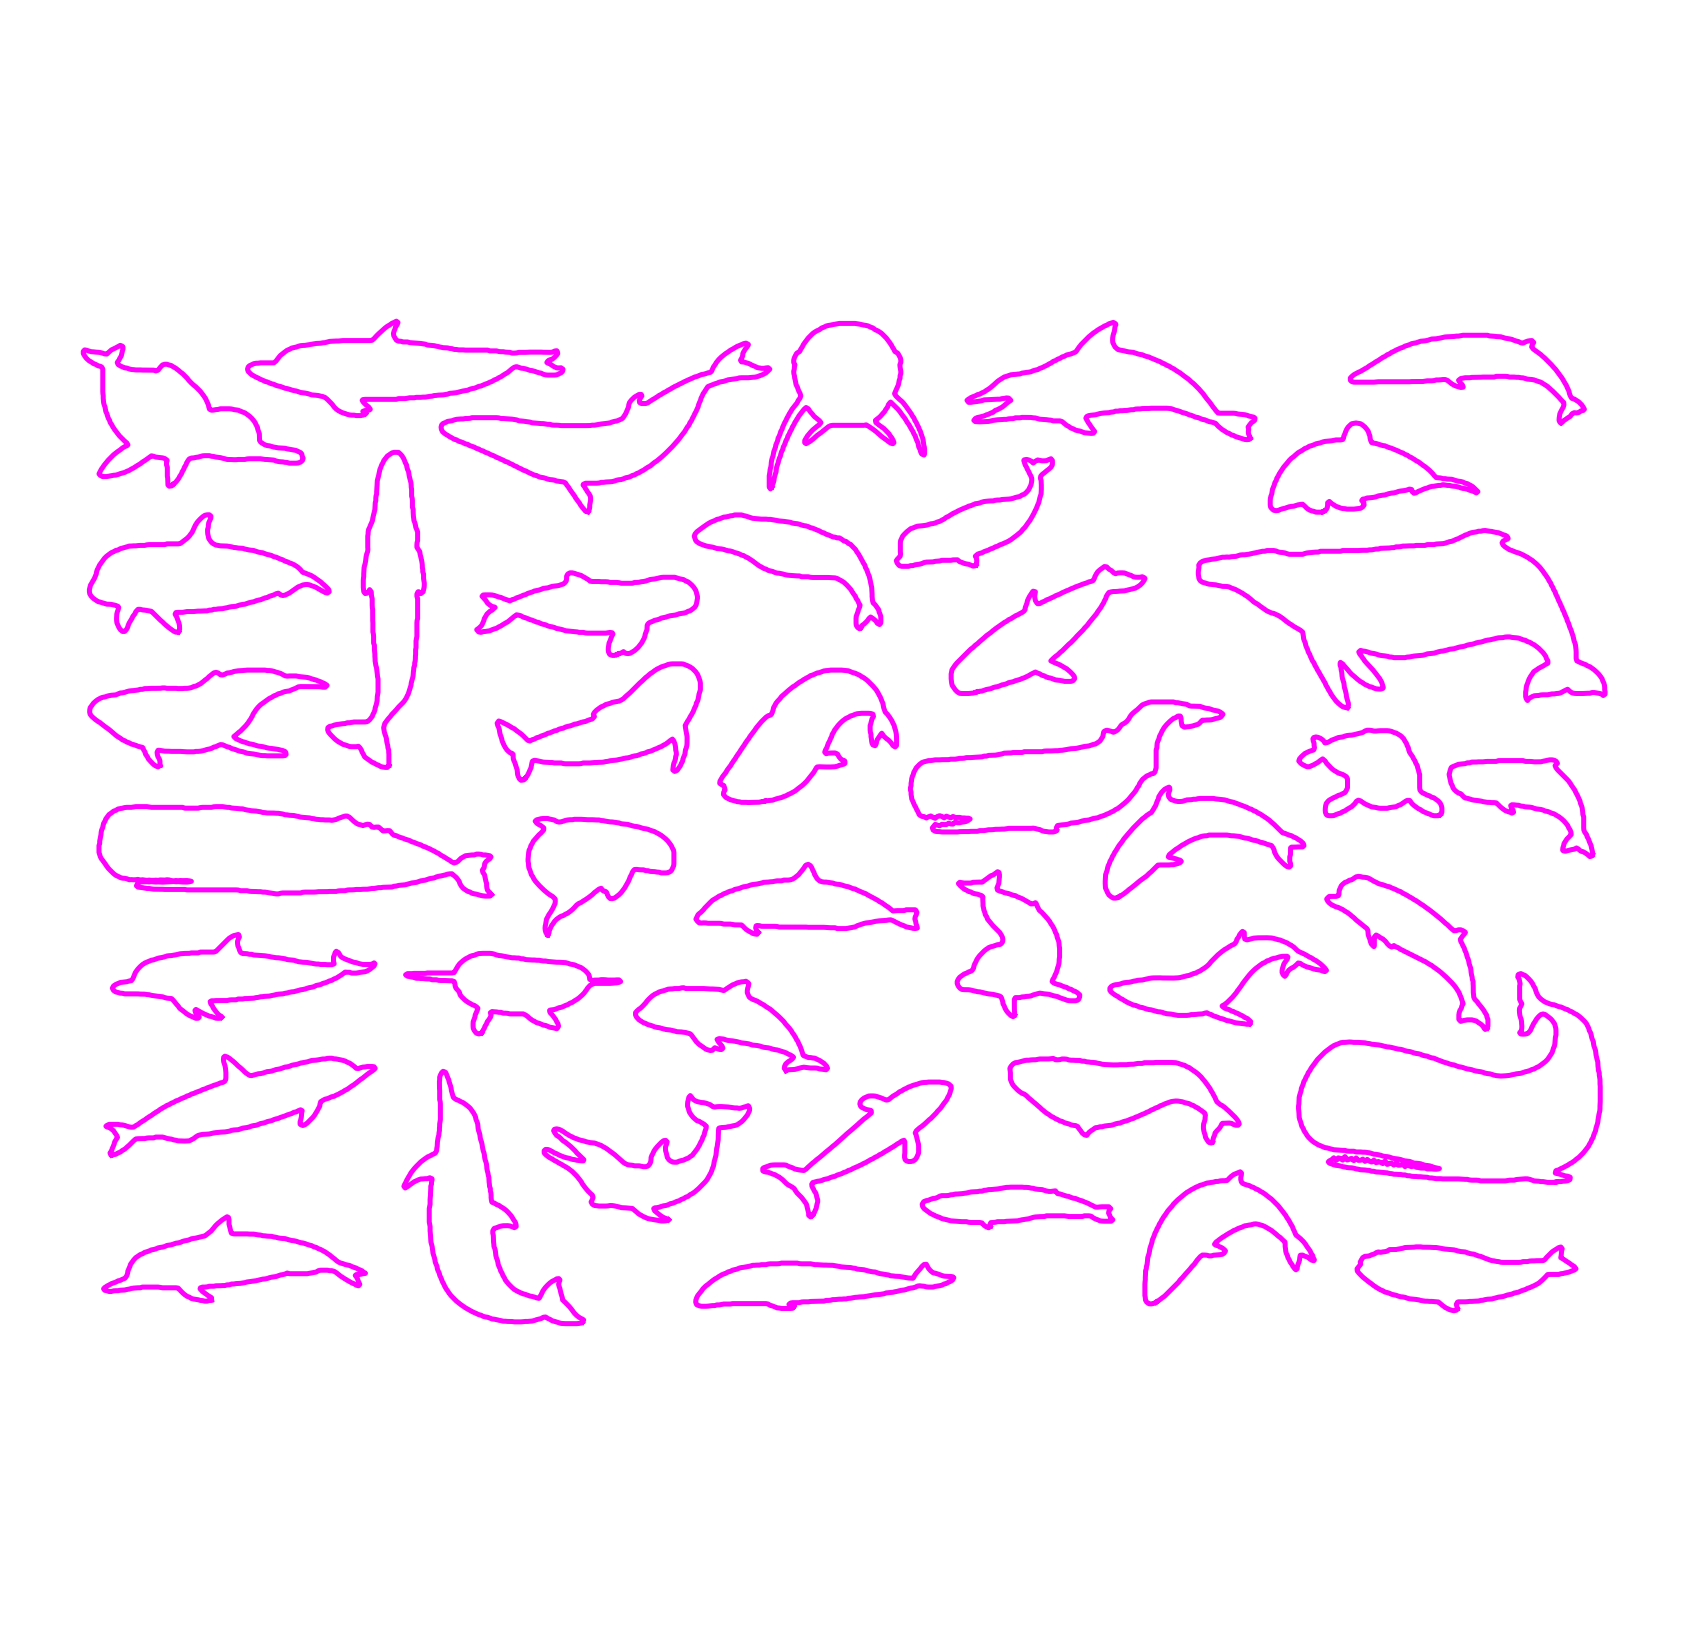

In [7]:
images_dir = 'C:/deep-signature-data/vector-images/yellow_background/2x'
# images_dir = 'C:/deep-signature-data/vector-images/2x'
image_file_paths = []
for (dir_path, dir_names, file_names) in walk(images_dir):
    for file_name in file_names:
        image_file_paths.append(os.path.normpath(os.path.join(dir_path, file_name)))
    break

for image_file_index, image_file_path in enumerate(image_file_paths):
    stem = Path(image_file_path).stem

    image = skimage.io.imread(image_file_path)
    gray_image = skimage.color.rgb2gray(image)
    curves = skimage.measure.find_contours(gray_image)

    closed_curves = []
    for curve in curves:
        first_point = curve[0]
        last_point = curve[-1]
        distance = numpy.linalg.norm(x=first_point - last_point, ord=2)
        if distance < 1:
            closed_curves.append(curve)

    # closed_curves = curves

    external_curves = []
    for i, curve in enumerate(closed_curves):
        polygon = Polygon(curve)
        remove = False
        for j, ref_curve in enumerate(closed_curves):
            ref_polygon = Polygon(ref_curve)
            if (polygon.within(ref_polygon) is True) and (i != j):
                remove = True

        if not remove:
            if curve.shape[0] > 200:
                # centered_curve = curve_processing.center_curve(curve=curve)
                external_curves.append(curve)


    fig = plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.axis('equal')
    # plt.imshow(image)

    for curve in external_curves:
        x = curve[:, 0]
        y = curve[:, 1]
        # plt.plot(y, x, linewidth=3, color='dodgerblue')
        plt.plot(y, -x, linewidth=5, color='magenta')

    plt.show()

    # fig.savefig(os.path.join(os.path.normpath('C:/Users/Roy\OneDrive - Technion/Thesis/collection_demo/curves'), f'{stem}.png'))
    # plt.close(fig)
